<a href="https://colab.research.google.com/github/bongkyunSON/Fastcampus-ML/blob/main/ML_project_221116.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Learning Project

 - 데이콘 : 건설기계오일상태분류
 - https://dacon.io/competitions/official/236013/overview/description


1. **필요한 라이브러리와 데이터를 불러옵니다.**


2. **EDA를 수행합니다.** 이 때 EDA의 목적은 풀어야하는 문제를 위해서 수행됩니다.


3. **전처리를 수행합니다.** 이 때 중요한건 **feature engineering**을 어떻게 하느냐 입니다.


4. **데이터 분할을 합니다.** 이 때 train data와 test data 간의 분포 차이가 없는지 확인합니다.


5. **학습을 진행합니다.** 어떤 모델을 사용하여 학습할지 정합니다. 성능이 잘 나오는 GBM을 추천합니다.


6. **hyper-parameter tuning을 수행합니다.** 원하는 목표 성능이 나올 때 까지 진행합니다. 검증 단계를 통해 지속적으로 **overfitting이 되지 않게 주의**하세요.


7. **최종 테스트를 진행합니다.** 데이터 분석 대회 포맷에 맞는 submission 파일을 만들어서 성능을 확인해보세요.

## 1. 라이브러리, 데이터 불러오기

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 5.3 MB/s 
     |████████████████████████████████| 81 kB 10.1 MB/s 
     |████████████████████████████████| 209 kB 47.2 MB/s 
     |████████████████████████████████| 78 kB 5.3 MB/s 
     |████████████████████████████████| 147 kB 56.0 MB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 
     |████████████████████████████████| 112 kB 65.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=cf0c94fcbede7a1587d46437828e061fee9e137c0f8c77ea36a17a3ad5a9741e
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [2]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 모델들, 성능 평가
# (저는 일반적으로 정형데이터로 머신러닝 분석할 때는 이 2개 모델은 그냥 돌려봅니다. 특히 RF가 테스트하기 좋습니다.)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMClassifier
from lightgbm.sklearn import LGBMRegressor

# 상관관계 분석, VIF : 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
import optuna

In [3]:
# flag setting
data_reducing = False ## memory reducing technique
feature_reducing = False ## feature extraction (curse of dimensionality)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [49]:
# 데이터를 불러옵니다.
base_path = "/content/drive/MyDrive/Colab Notebooks/MachineLearning/data/Construction_machinery/"
train = pd.read_csv(base_path + "train.csv")
test = pd.read_csv(base_path + "test.csv")

## 2. EDA

- 데이터에서 찾아야 하는 기초적인 내용들을 확인합니다.


- class imbalance, target distribution, outlier, correlation을 확인합니다.

In [6]:
train

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
0,TRAIN_00000,COMPONENT3,1486,2011,7,200,0,3,93,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,154.0,75,0
1,TRAIN_00001,COMPONENT2,1350,2021,51,375,0,2,19,0,...,2.0,4.0,6.0,216.0,1454.0,0,NaN,44.0,652,0
2,TRAIN_00002,COMPONENT2,2415,2015,2,200,0,110,1,1,...,0.0,3.0,39.0,11261.0,41081.0,0,NaN,72.6,412,1
3,TRAIN_00003,COMPONENT3,7389,2010,2,200,0,8,3,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,133.3,7,0
4,TRAIN_00004,COMPONENT3,3954,2015,4,200,0,1,157,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,133.1,128,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,TRAIN_14090,COMPONENT3,1616,2014,8,200,0,2,201,1,...,NaN,NaN,NaN,NaN,NaN,0,NaN,135.4,16,0
14091,TRAIN_14091,COMPONENT1,2784,2013,2,200,0,3,85,0,...,NaN,NaN,NaN,NaN,NaN,0,14.5,117.5,1408,0
14092,TRAIN_14092,COMPONENT3,1788,2008,9,550,0,6,0,1,...,NaN,NaN,NaN,NaN,NaN,0,NaN,54.0,1301,0
14093,TRAIN_14093,COMPONENT2,2498,2009,19,550,0,2,4,0,...,7.0,8.0,100.0,1625.0,18890.0,0,NaN,44.3,652,0


In [7]:
test

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN
0,TEST_0000,COMPONENT1,2192,2016,200,0,0,0,1,12,0.0,0,0,0,10,0,0,91.3,1091
1,TEST_0001,COMPONENT3,2794,2011,200,0,0,2,1,278,0.0,3,0,0,2732,1,0,126.9,12
2,TEST_0002,COMPONENT2,1982,2010,200,0,0,0,16,5,0.0,0,0,0,11,0,0,44.3,714
3,TEST_0003,COMPONENT3,1404,2009,200,0,0,3,4,163,0.0,4,3,0,8007,0,0,142.8,94
4,TEST_0004,COMPONENT2,8225,2013,200,0,0,0,6,13,0.0,0,0,0,16,0,0,63.4,469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,TEST_6036,COMPONENT3,1714,2014,200,0,0,3,130,1047,0.0,65,5,2,1999,0,0,71.2,1163
6037,TEST_6037,COMPONENT3,4131,2016,200,0,0,5,2,736,0.0,5,0,0,693,0,0,137.8,13
6038,TEST_6038,COMPONENT3,4325,2014,200,0,0,0,0,53,0.0,0,0,0,69,0,0,302.2,13
6039,TEST_6039,COMPONENT2,1364,2013,200,0,0,0,62,2,0.0,0,0,0,5,0,0,51.1,478


### train과 test, columns 차이가 있다 drop 할건지, 0으로 체울건지 아니면 다른 방안으로 null값을 처리할지 고민하기

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 54 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   14095 non-null  object 
 1   COMPONENT_ARBITRARY  14095 non-null  object 
 2   ANONYMOUS_1          14095 non-null  int64  
 3   YEAR                 14095 non-null  int64  
 4   SAMPLE_TRANSFER_DAY  14095 non-null  int64  
 5   ANONYMOUS_2          14095 non-null  int64  
 6   AG                   14095 non-null  int64  
 7   AL                   14095 non-null  int64  
 8   B                    14095 non-null  int64  
 9   BA                   14095 non-null  int64  
 10  BE                   14095 non-null  int64  
 11  CA                   14095 non-null  int64  
 12  CD                   12701 non-null  float64
 13  CO                   14095 non-null  int64  
 14  CR                   14095 non-null  int64  
 15  CU                   14095 non-null 

In [9]:
train.isnull().sum()

ID                         0
COMPONENT_ARBITRARY        0
ANONYMOUS_1                0
YEAR                       0
SAMPLE_TRANSFER_DAY        0
ANONYMOUS_2                0
AG                         0
AL                         0
B                          0
BA                         0
BE                         0
CA                         0
CD                      1394
CO                         0
CR                         0
CU                         0
FH2O                   10205
FNOX                   10205
FOPTIMETHGLY           10205
FOXID                  10205
FSO4                   10205
FTBN                   10205
FE                         0
FUEL                   10205
H2O                        0
K                       2299
LI                         0
MG                         0
MN                         0
MO                         0
NA                         0
NI                         0
P                          0
PB                         0
PQINDEX       

### F로 시작하는 컬럼들과 U로 시작하는 컬럼들의 결측치가 패턴을 보이는것같다

In [10]:
train.columns

Index(['ID', 'COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR',
       'SAMPLE_TRANSFER_DAY', 'ANONYMOUS_2', 'AG', 'AL', 'B', 'BA', 'BE', 'CA',
       'CD', 'CO', 'CR', 'CU', 'FH2O', 'FNOX', 'FOPTIMETHGLY', 'FOXID', 'FSO4',
       'FTBN', 'FE', 'FUEL', 'H2O', 'K', 'LI', 'MG', 'MN', 'MO', 'NA', 'NI',
       'P', 'PB', 'PQINDEX', 'S', 'SB', 'SI', 'SN', 'SOOTPERCENTAGE', 'TI',
       'U100', 'U75', 'U50', 'U25', 'U20', 'U14', 'U6', 'U4', 'V', 'V100',
       'V40', 'ZN', 'Y_LABEL'],
      dtype='object')

0    12892
1     1203
Name: Y_LABEL, dtype: int64

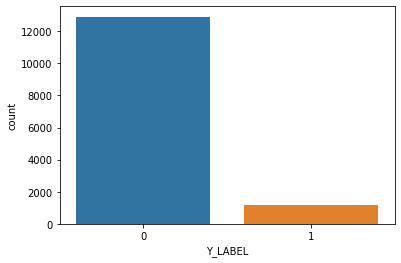

In [11]:
#불량이 10배정도 차이난다
display(train["Y_LABEL"].value_counts())
sns.countplot(data=train, x="Y_LABEL")

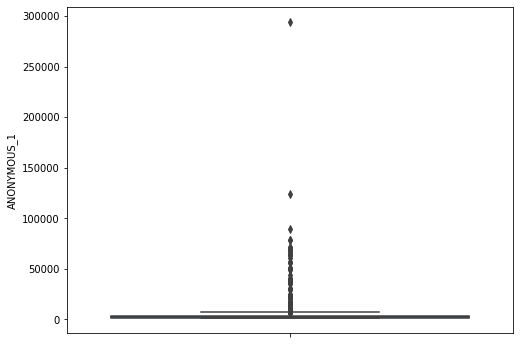

In [12]:
#ANONYMOUS_1 - 이 column은 뭐지??? 아웃라이어가 이상하다....
plt.figure(figsize = (8,6))
sns.boxplot(data=train, y="ANONYMOUS_1")

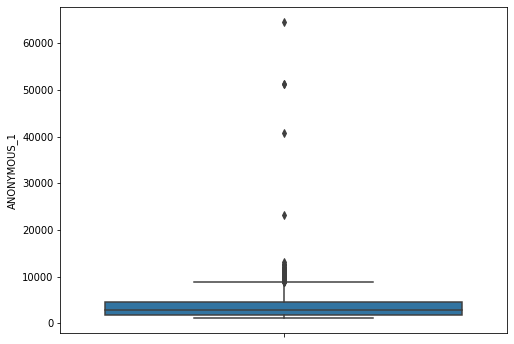

In [13]:
Y_1 = train[train["Y_LABEL"] ==1]
Y_1

plt.figure(figsize = (8,6))
sns.boxplot(data=Y_1, y="ANONYMOUS_1")

In [14]:
ANONYMOUS_1_20000 = train[train["ANONYMOUS_1"] > 300000]
ANONYMOUS_1_20000#[ANONYMOUS_1_20000["Y_LABEL"] == 1]

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL


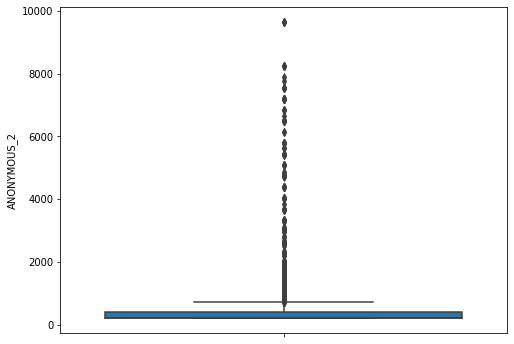

In [15]:
#ANONYMOUS_2 - 이 column은 뭐지??? 아웃라이어가 이상하다....
plt.figure(figsize = (8,6))
sns.boxplot(data=train, y="ANONYMOUS_2")

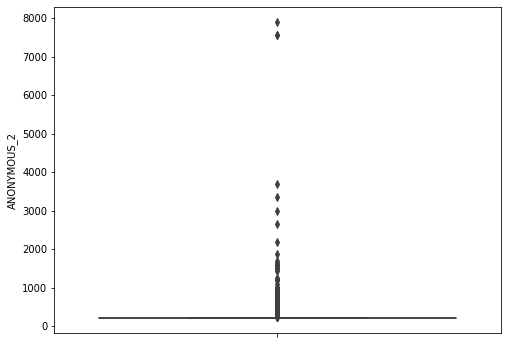

In [16]:
Y_1 = train[train["Y_LABEL"] ==1]
Y_1

plt.figure(figsize = (8,6))
sns.boxplot(data=Y_1, y="ANONYMOUS_2")

In [17]:
ANONYMOUS_2_2000 = train[train["ANONYMOUS_2"] > 2000]
ANONYMOUS_2_2000

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
59,TRAIN_00059,COMPONENT2,8483,2018,2,7550,0,0,3,0,...,3.0,5.0,19.0,428.0,1304.0,0,NaN,58.1,382,1
383,TRAIN_00383,COMPONENT3,5890,2017,3,5100,0,1,1,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,140.8,11,0
436,TRAIN_00436,COMPONENT4,6780,2017,6,5800,0,5,2,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,83.4,1505,0
647,TRAIN_00647,COMPONENT2,3389,2017,3,2650,0,0,1,0,...,85.0,102.0,666.0,8788.0,11935.0,0,NaN,57.4,356,0
983,TRAIN_00983,COMPONENT1,6925,2017,2,6150,0,1,1,0,...,NaN,NaN,NaN,NaN,NaN,0,12.6,87.4,936,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13469,TRAIN_13469,COMPONENT3,123788,2017,0,6654,0,13,1,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,124.3,74,0
13705,TRAIN_13705,COMPONENT1,4130,2017,6,3000,0,68,3,0,...,NaN,NaN,NaN,NaN,NaN,0,10.2,68.8,1042,1
13965,TRAIN_13965,COMPONENT2,7402,2017,7,6500,0,5,23,0,...,16.0,32.0,131.0,6895.0,29629.0,0,NaN,66.2,126,0
14040,TRAIN_14040,COMPONENT1,5519,2017,4,4750,0,0,10,0,...,NaN,NaN,NaN,NaN,NaN,0,8.3,47.8,859,0


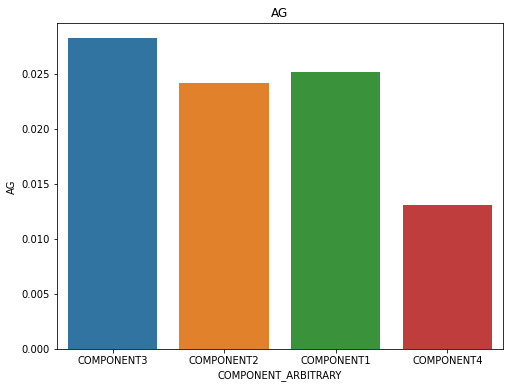

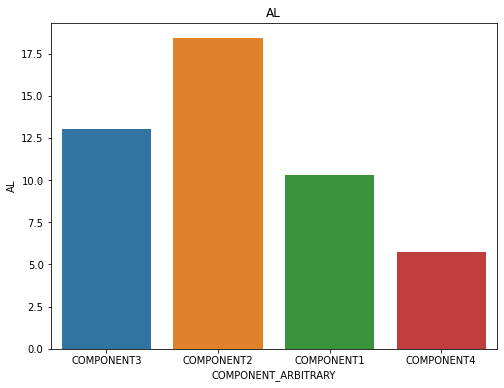

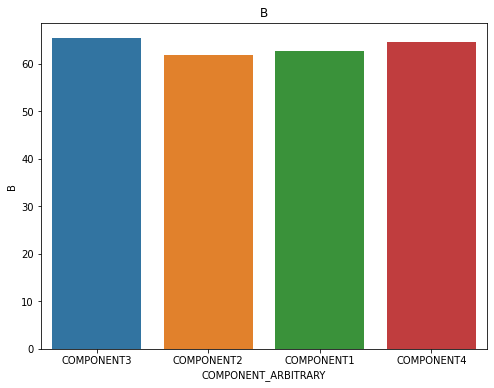

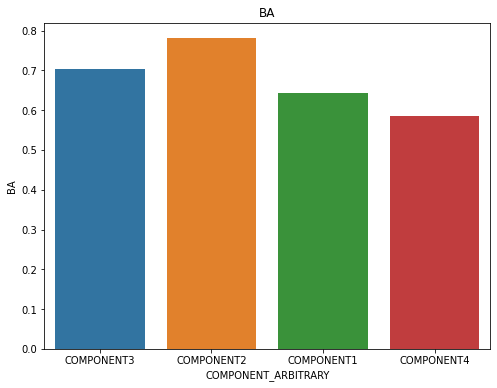

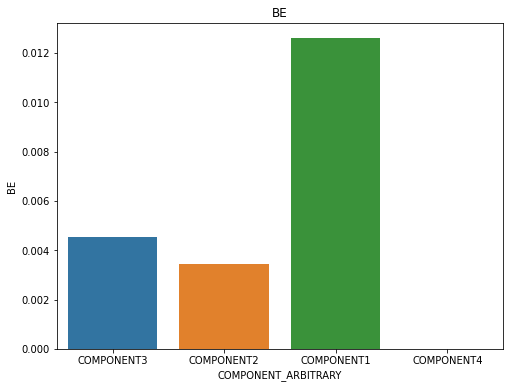

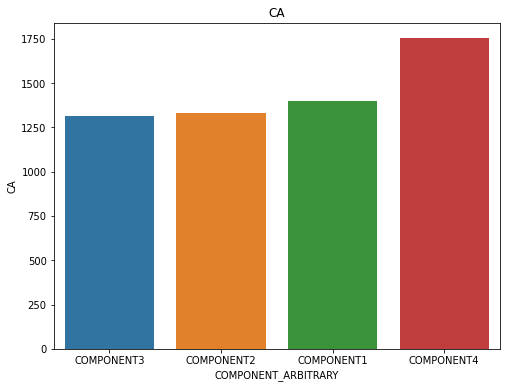

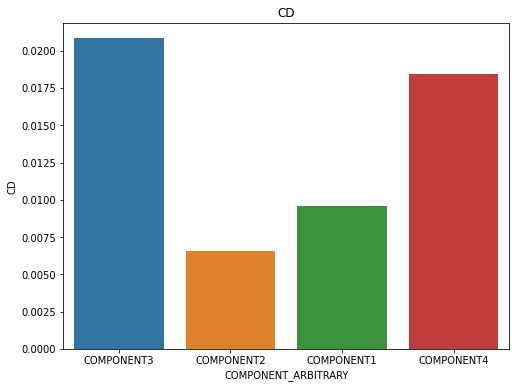

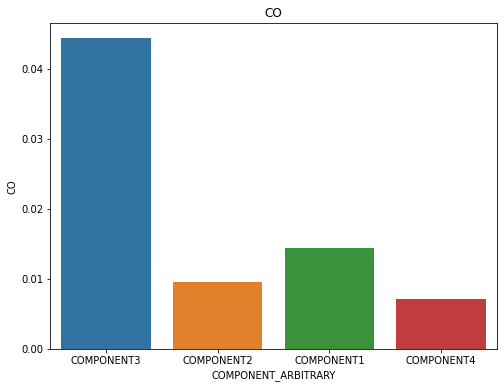

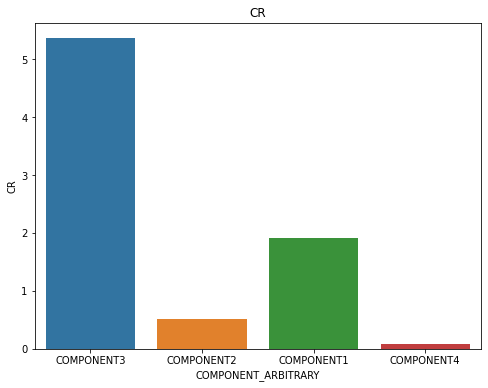

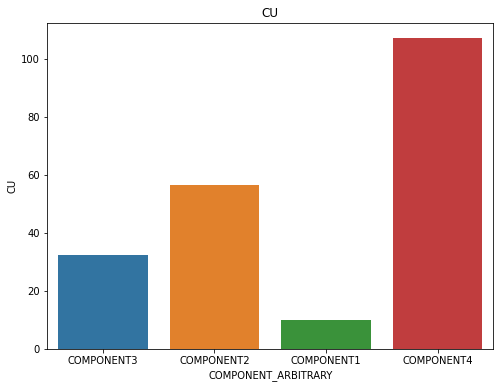

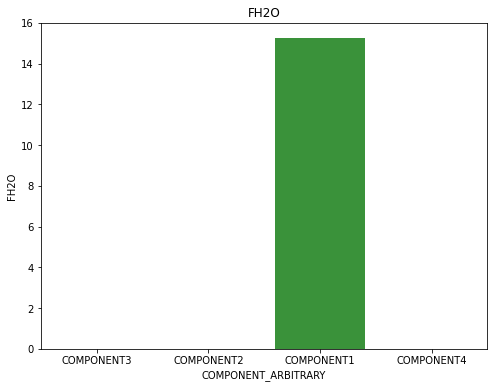

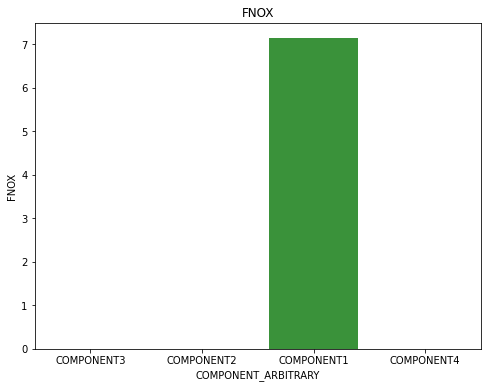

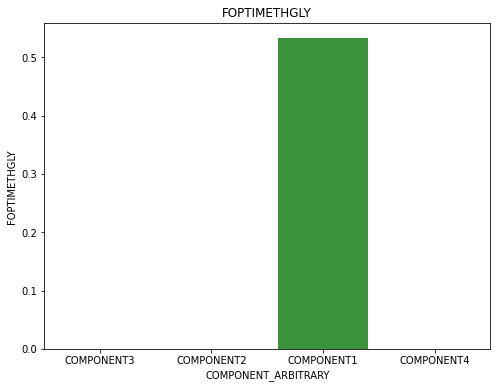

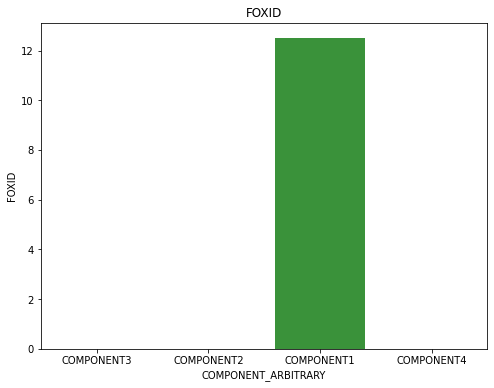

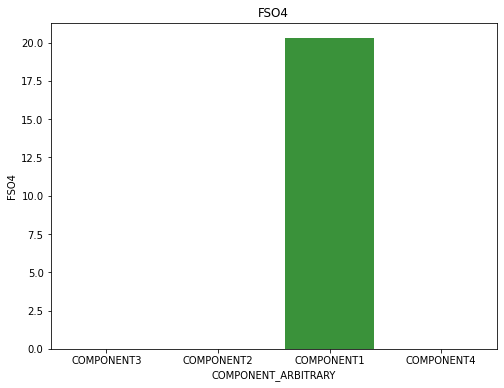

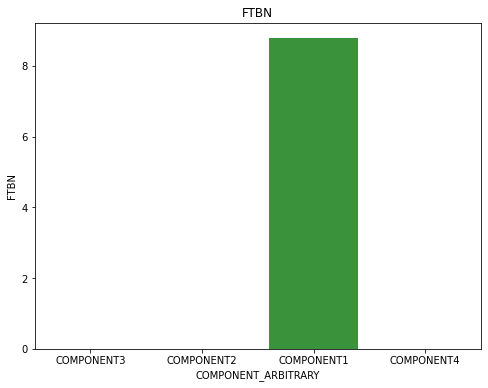

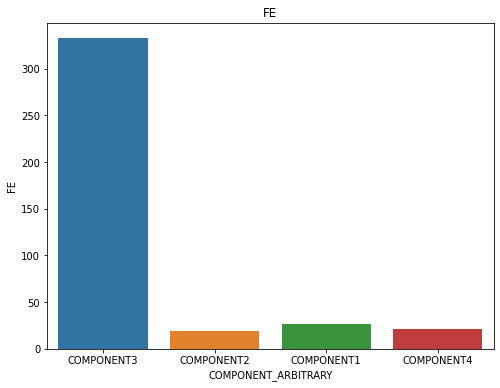

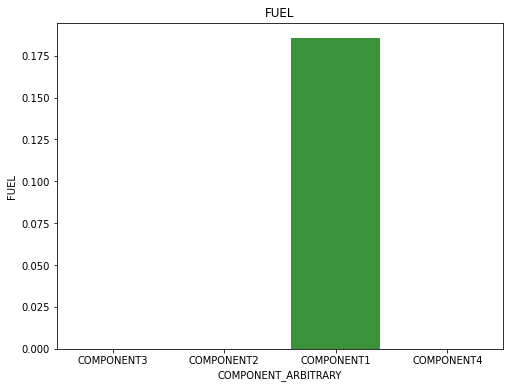

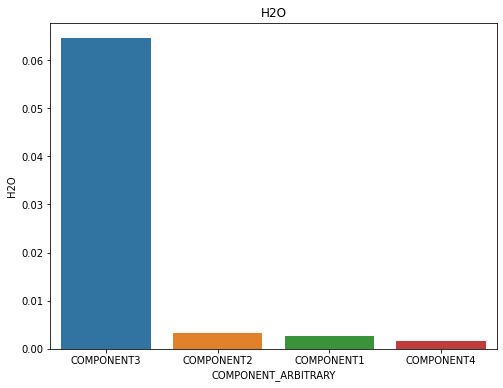

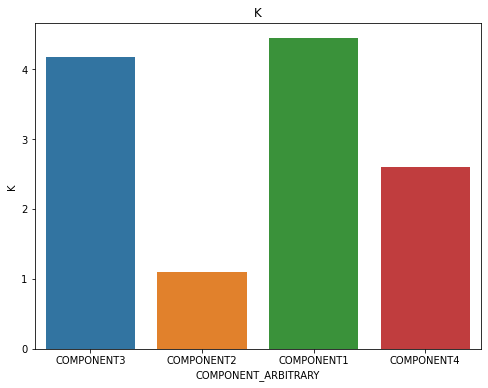

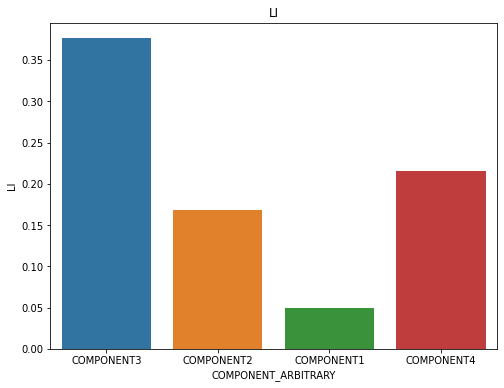

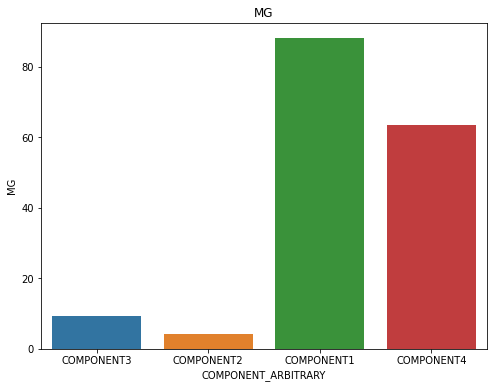

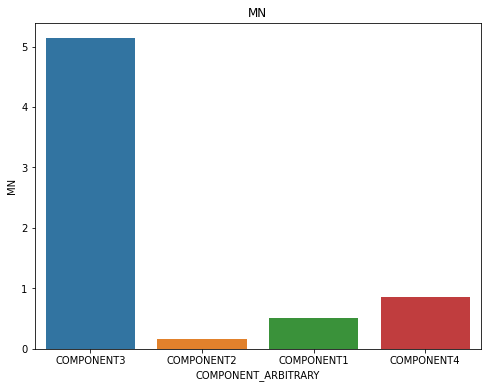

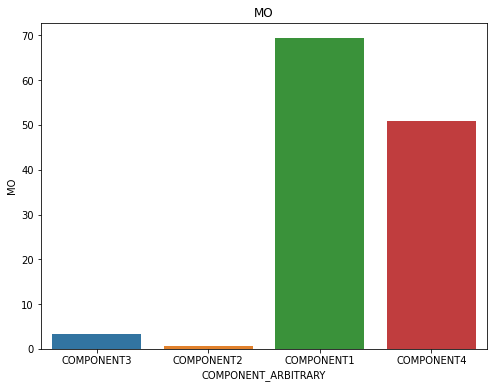

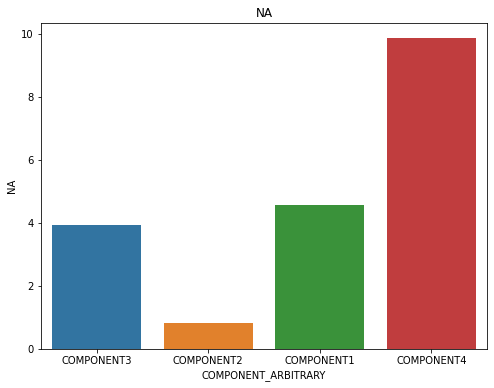

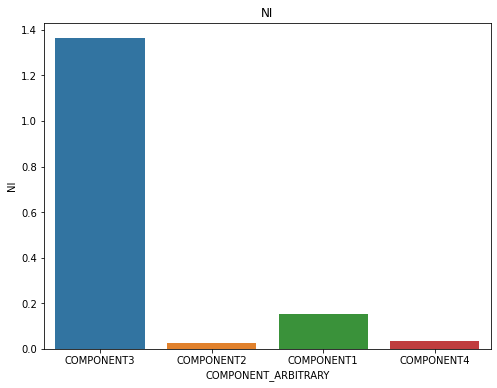

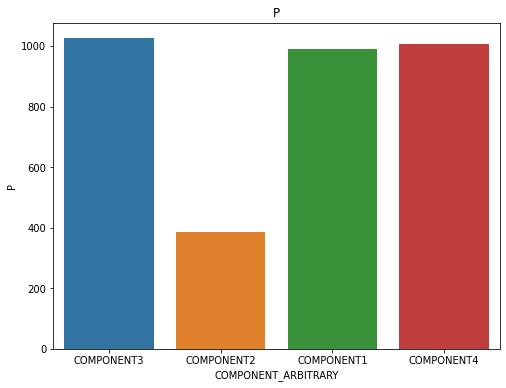

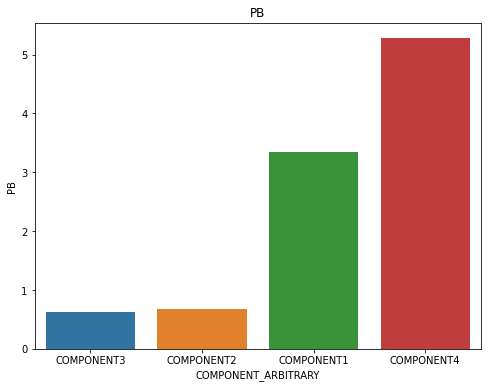

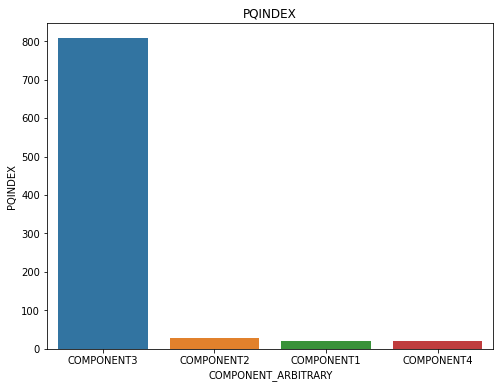

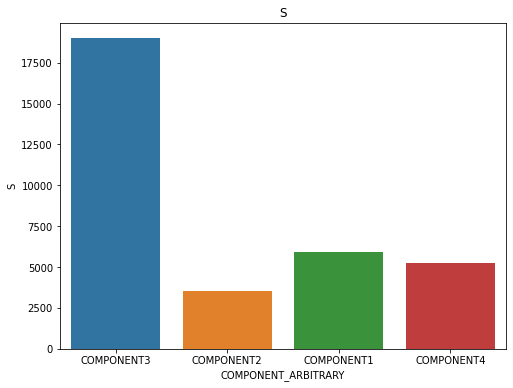

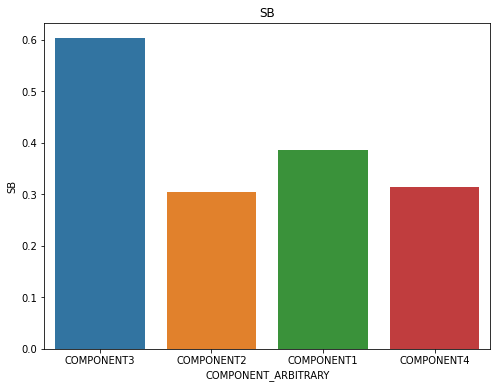

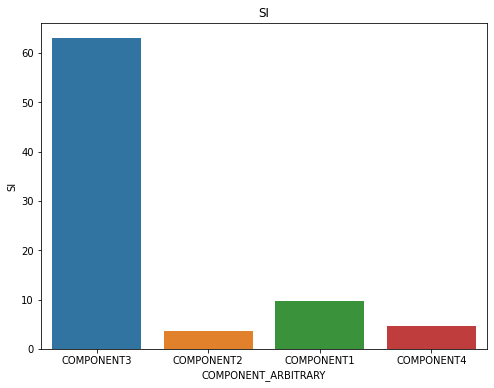

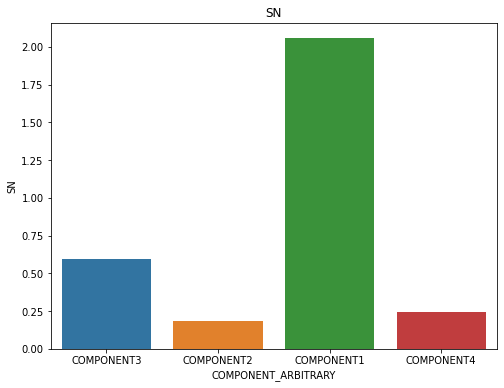

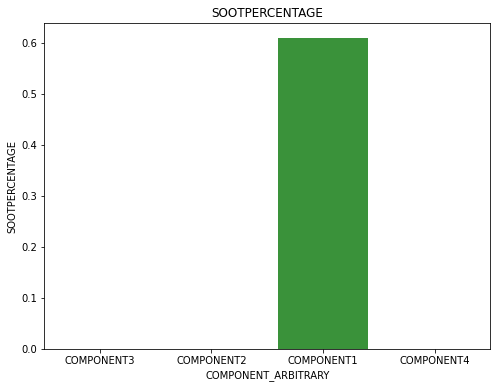

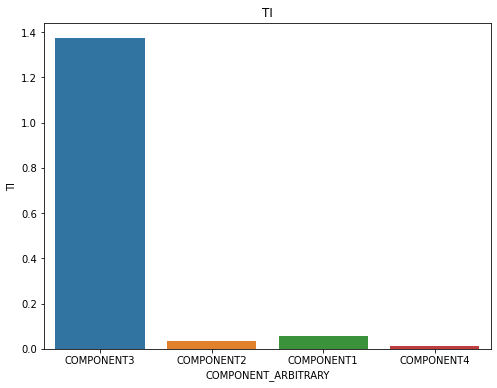

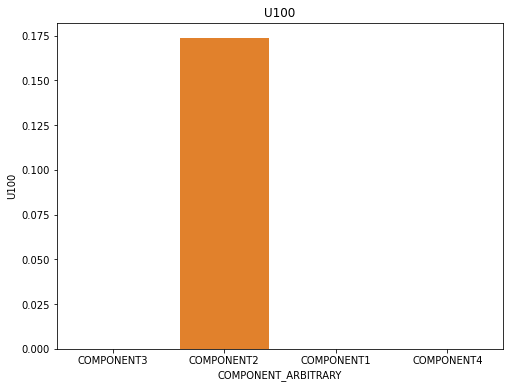

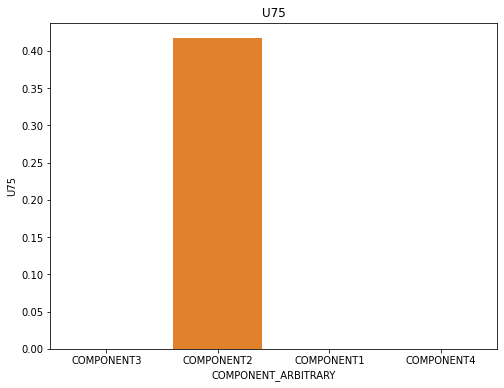

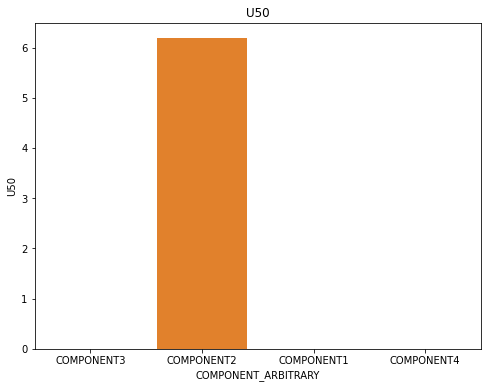

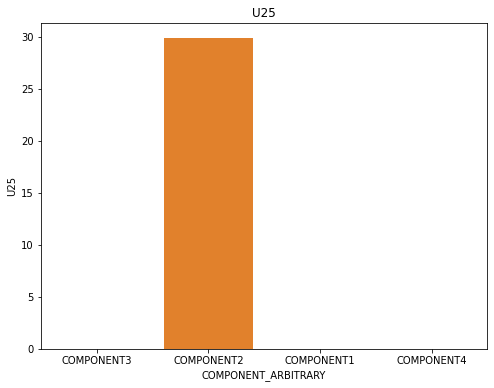

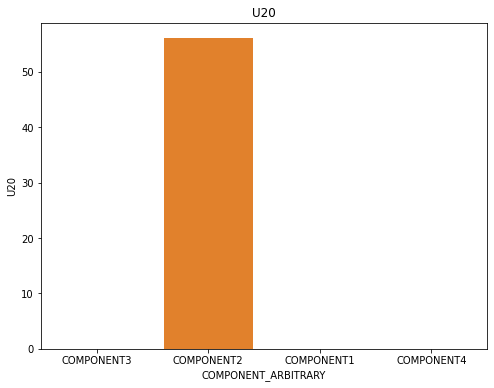

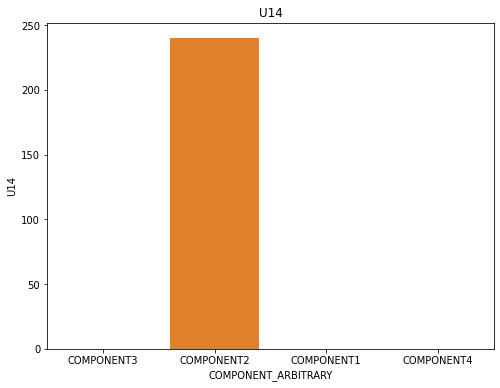

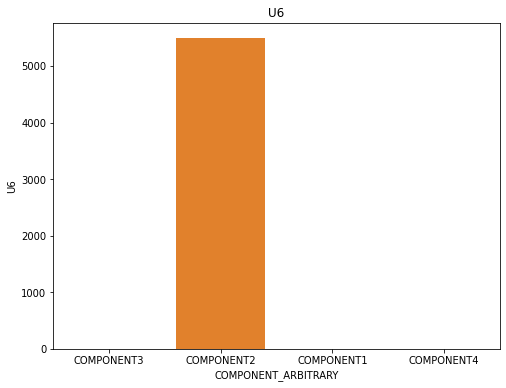

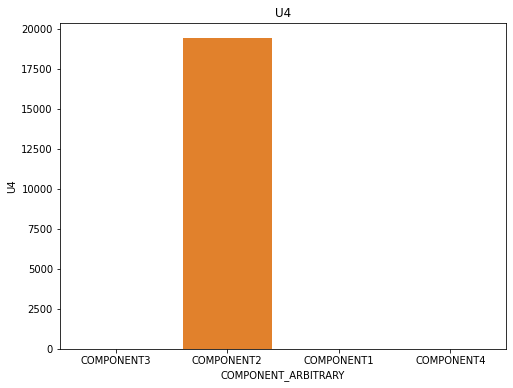

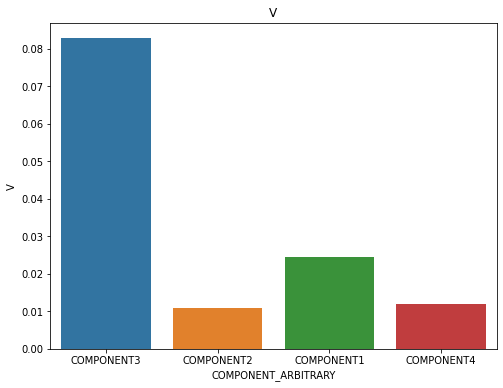

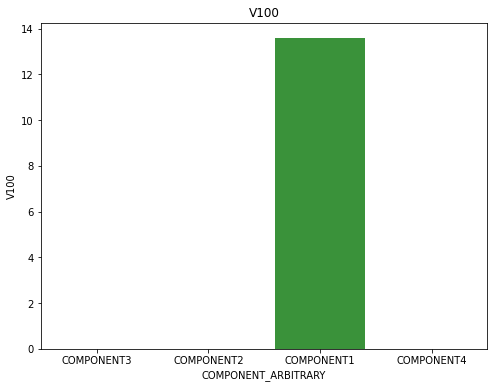

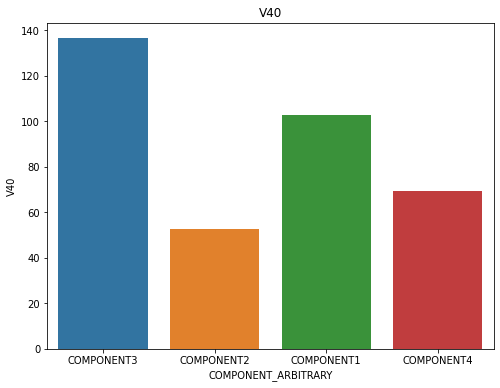

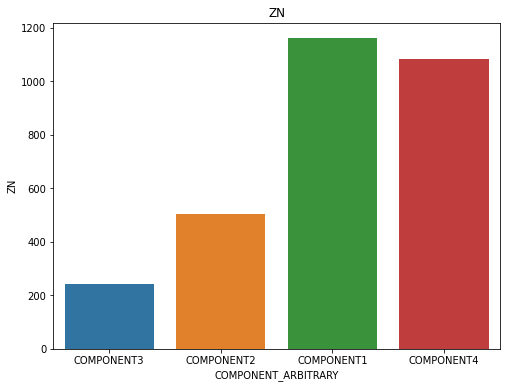

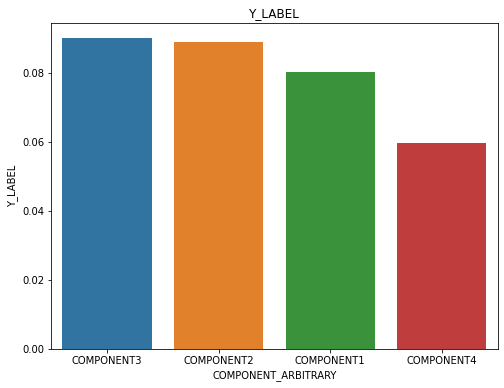

In [18]:
train_list = ['AG', 'AL', 'B', 'BA', 'BE', 'CA',
       'CD', 'CO', 'CR', 'CU', 'FH2O', 'FNOX', 'FOPTIMETHGLY', 'FOXID', 'FSO4',
       'FTBN', 'FE', 'FUEL', 'H2O', 'K', 'LI', 'MG', 'MN', 'MO', 'NA', 'NI',
       'P', 'PB', 'PQINDEX', 'S', 'SB', 'SI', 'SN', 'SOOTPERCENTAGE', 'TI',
       'U100', 'U75', 'U50', 'U25', 'U20', 'U14', 'U6', 'U4', 'V', 'V100',
       'V40', 'ZN', 'Y_LABEL']



for n in range(len(train_list)):
    plt.figure(figsize=(8, 6))
    plt.title(train_list[n])
    sns.barplot(data=train, x="COMPONENT_ARBITRARY", y=train_list[n], ci=None)
    plt.show()

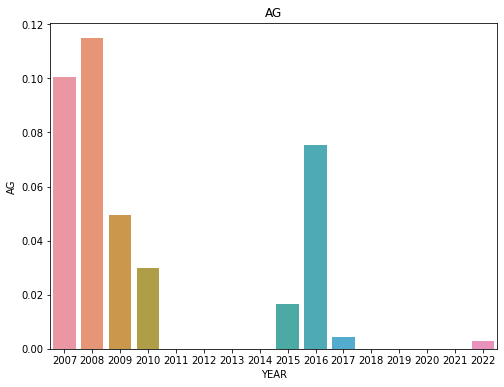

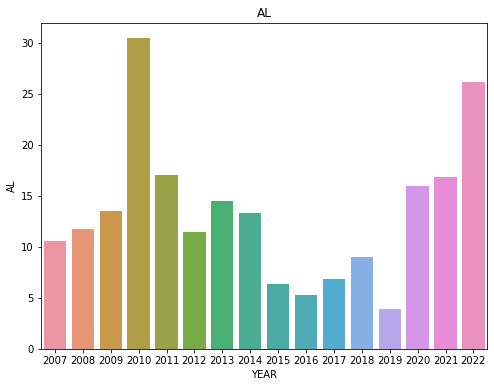

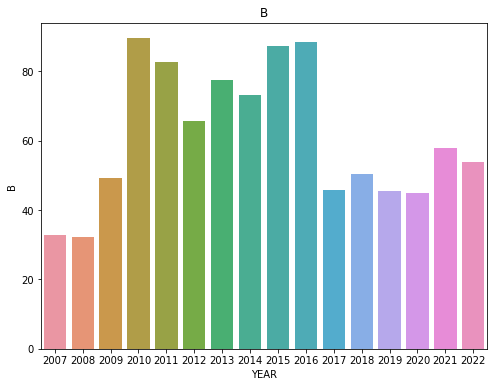

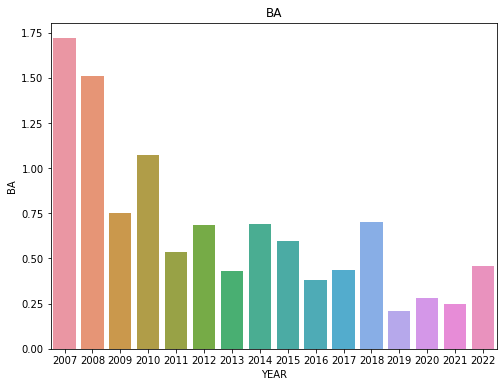

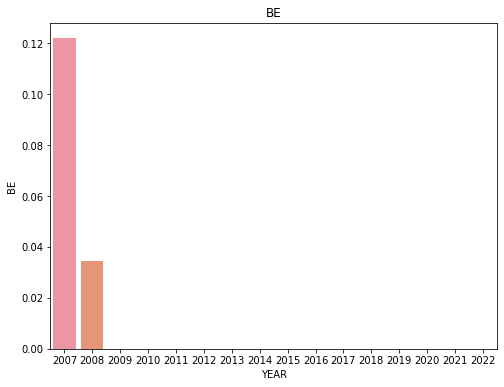

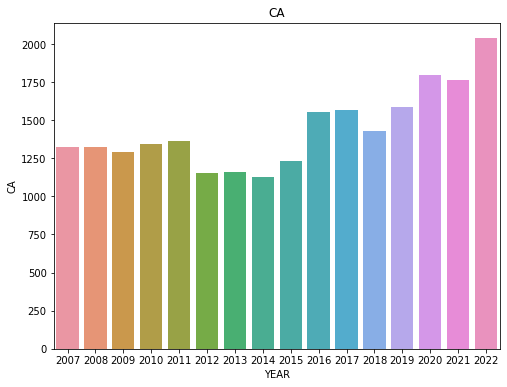

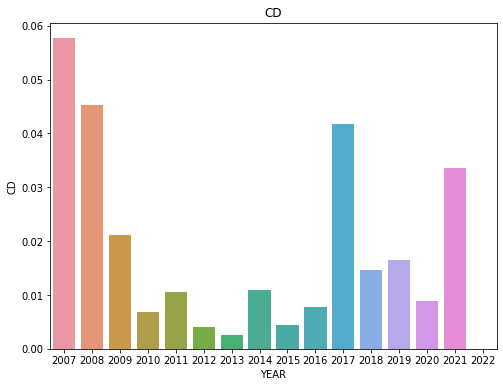

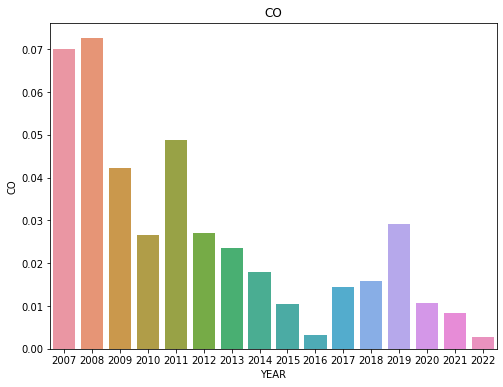

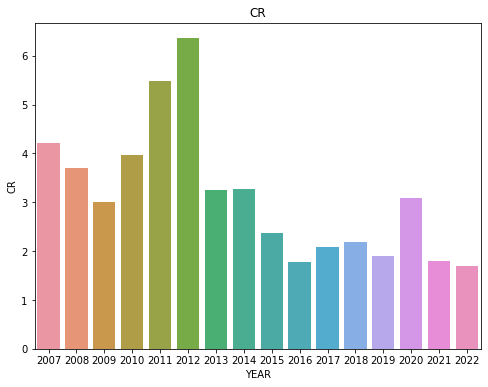

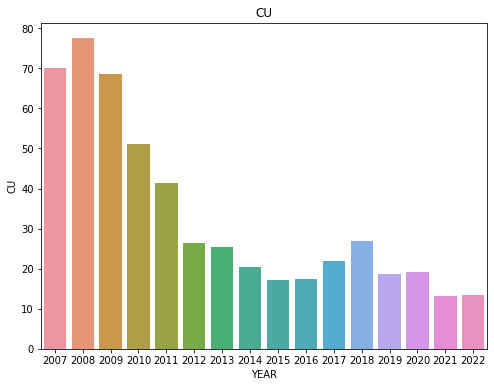

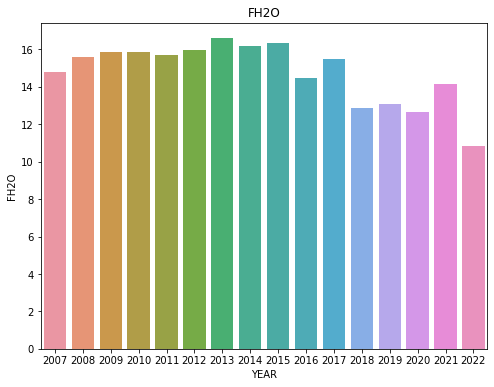

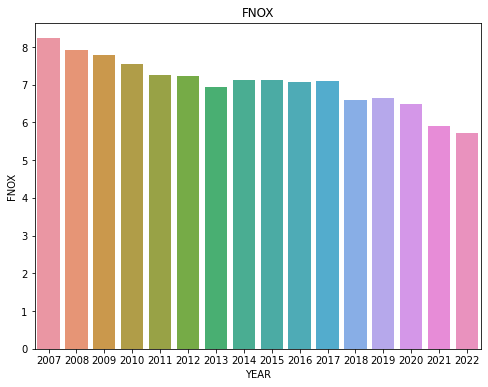

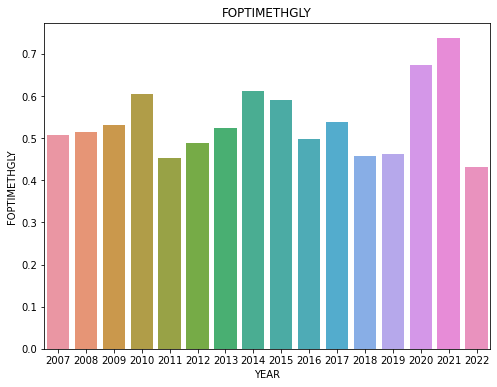

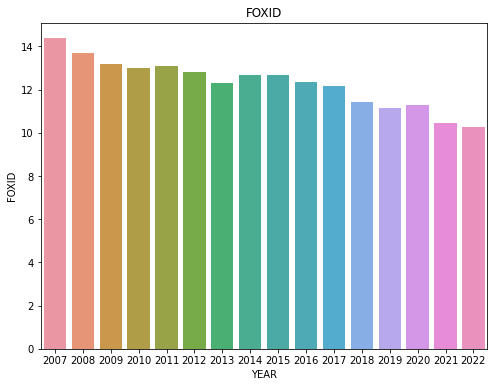

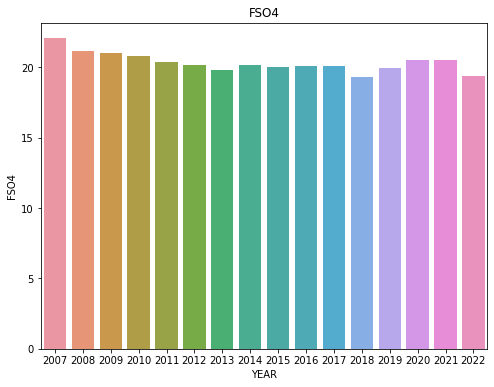

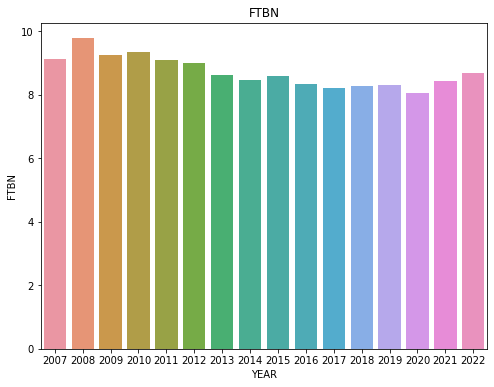

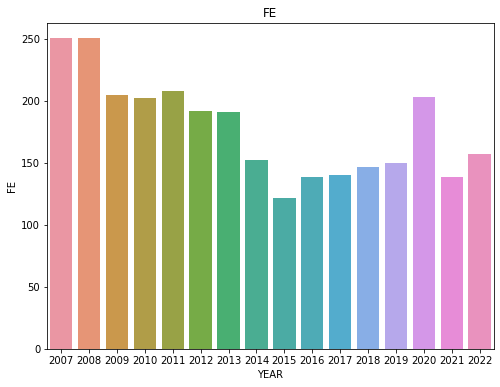

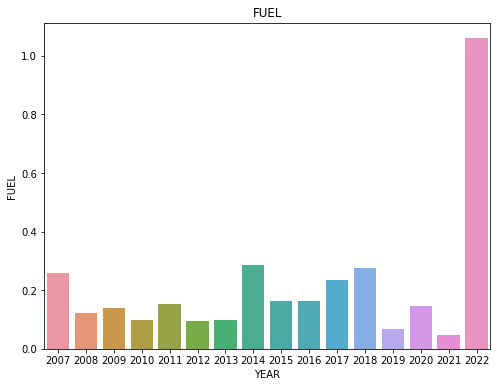

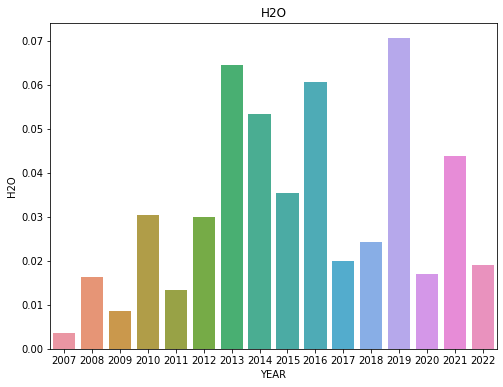

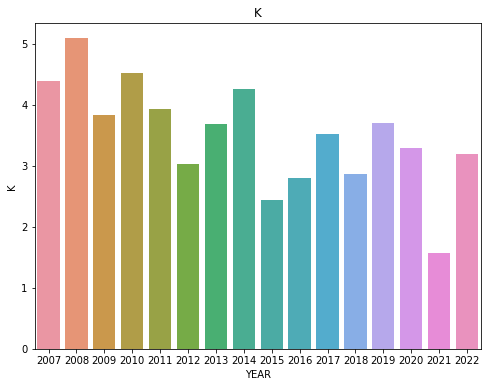

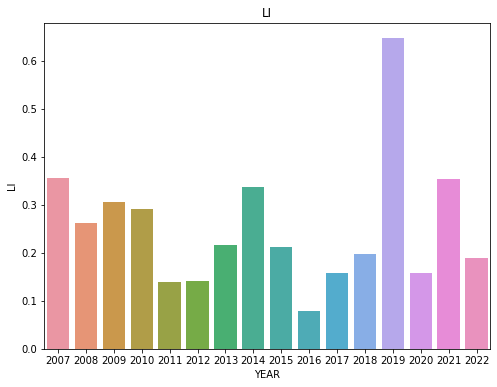

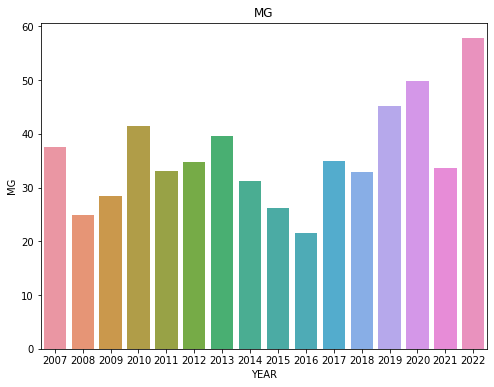

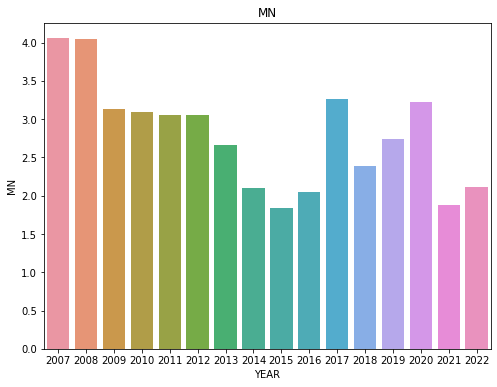

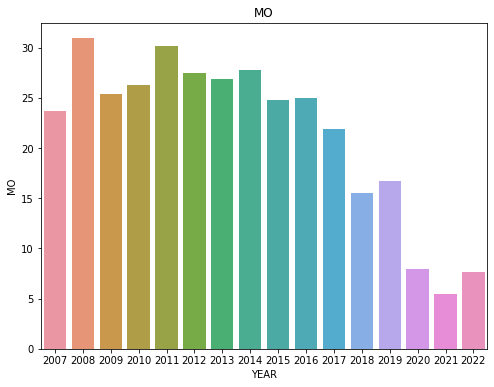

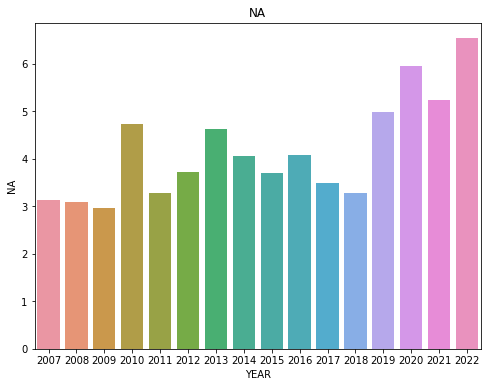

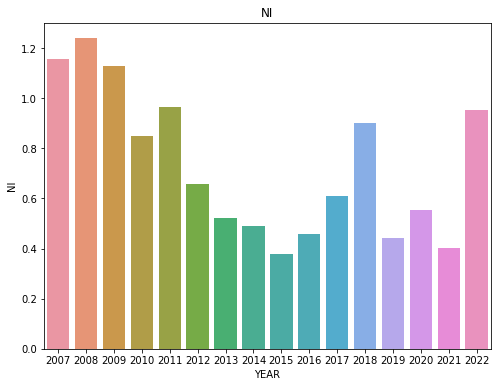

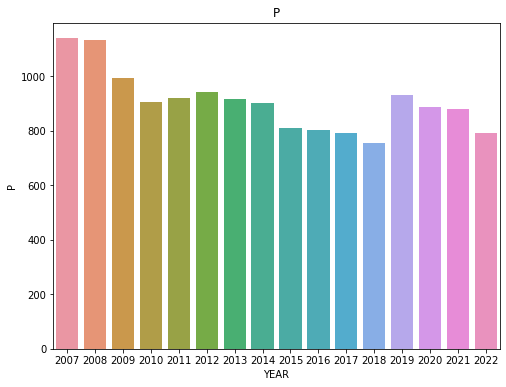

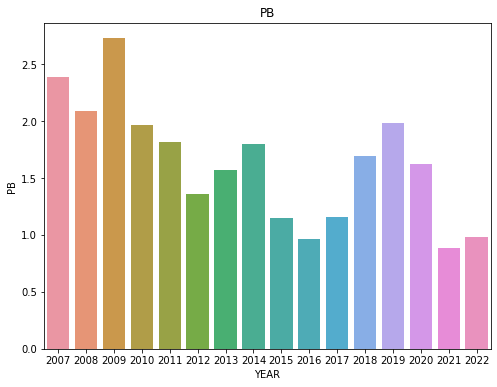

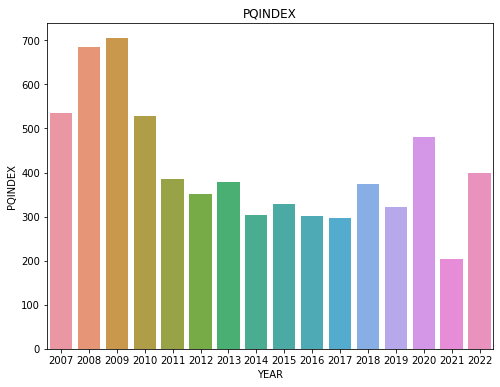

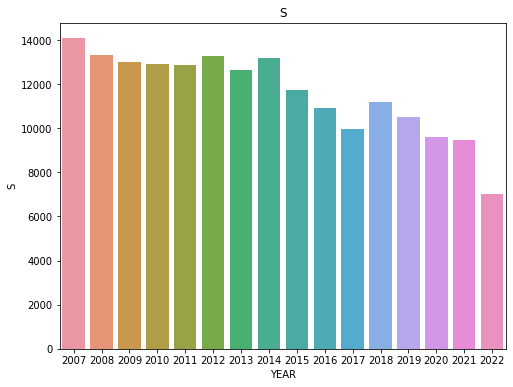

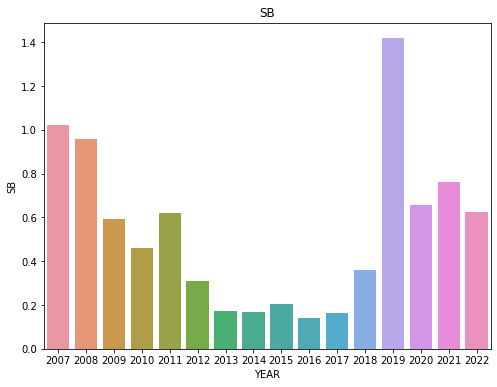

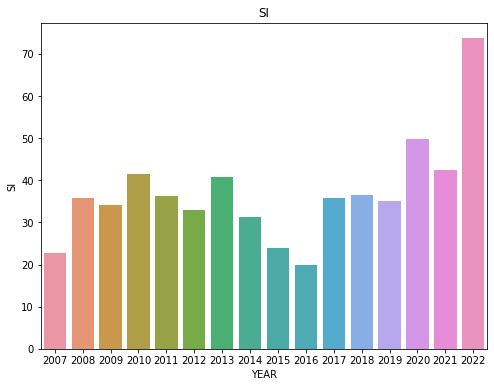

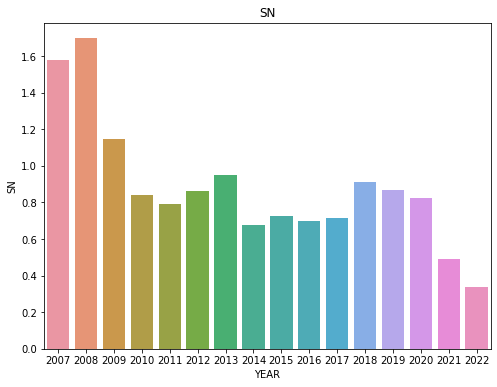

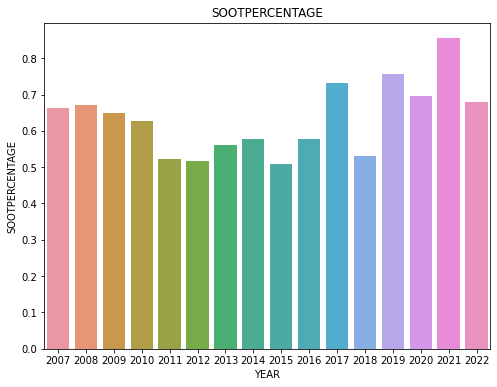

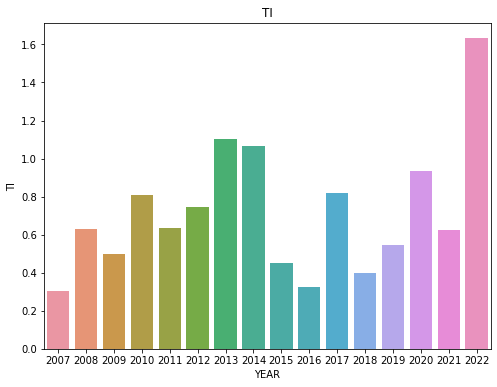

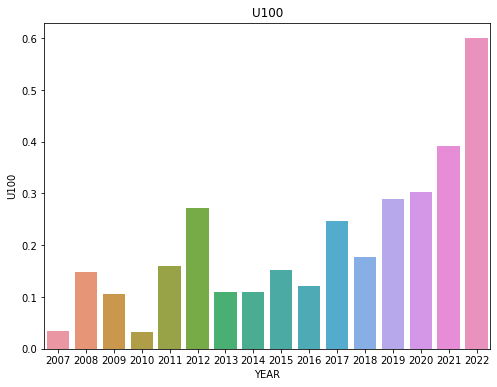

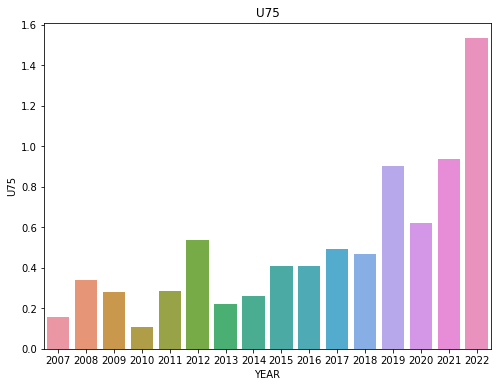

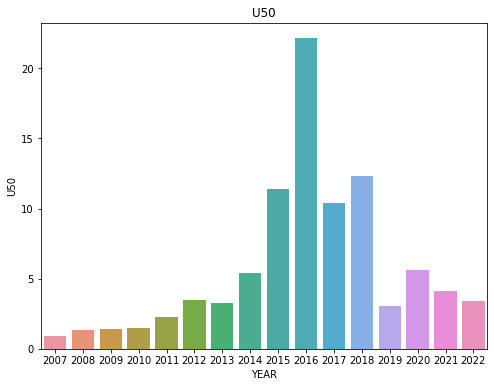

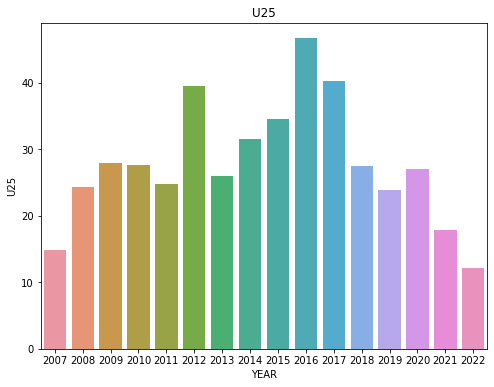

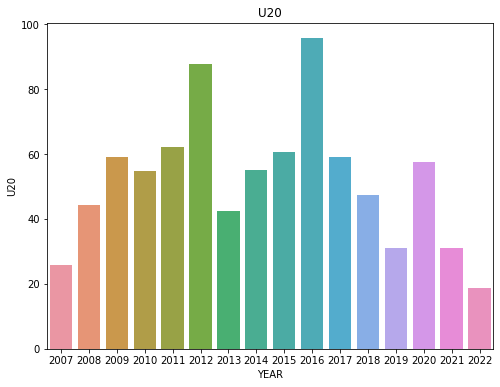

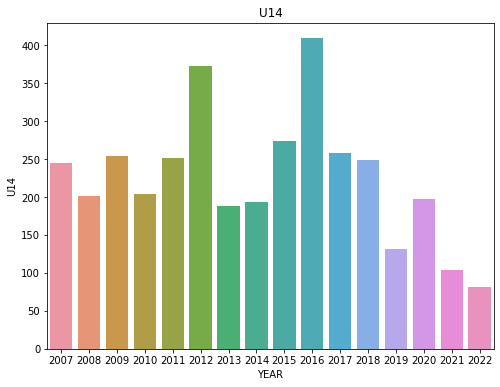

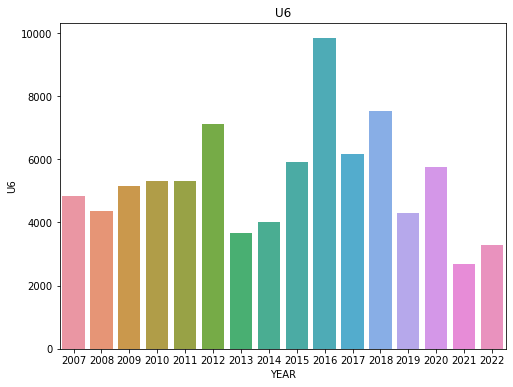

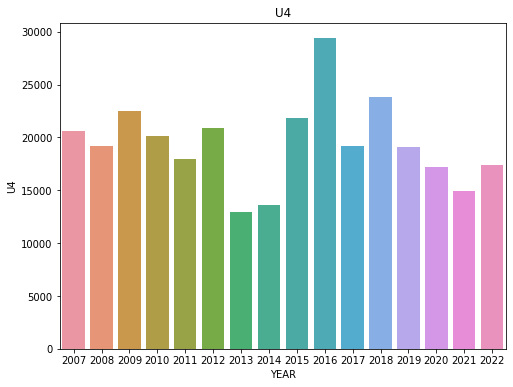

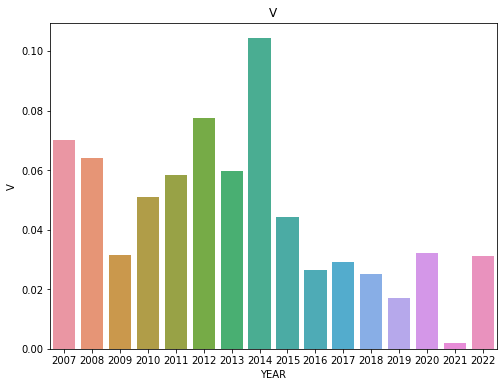

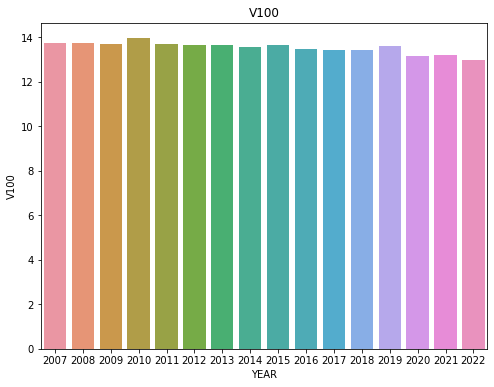

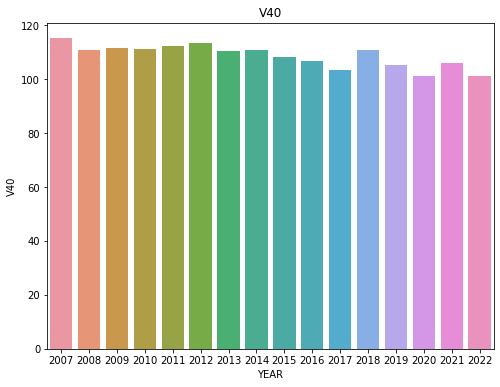

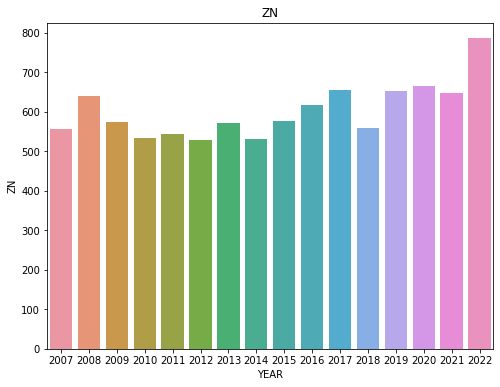

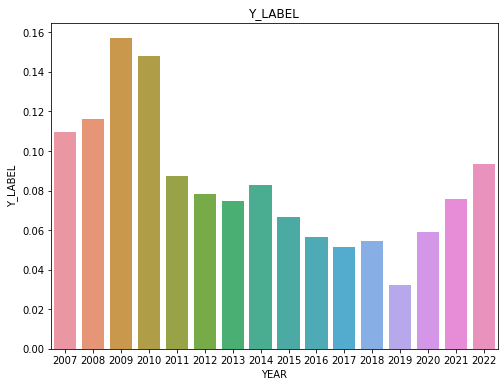

In [19]:
train_list = ['AG', 'AL', 'B', 'BA', 'BE', 'CA',
       'CD', 'CO', 'CR', 'CU', 'FH2O', 'FNOX', 'FOPTIMETHGLY', 'FOXID', 'FSO4',
       'FTBN', 'FE', 'FUEL', 'H2O', 'K', 'LI', 'MG', 'MN', 'MO', 'NA', 'NI',
       'P', 'PB', 'PQINDEX', 'S', 'SB', 'SI', 'SN', 'SOOTPERCENTAGE', 'TI',
       'U100', 'U75', 'U50', 'U25', 'U20', 'U14', 'U6', 'U4', 'V', 'V100',
       'V40', 'ZN', 'Y_LABEL']



for n in range(len(train_list)):
    plt.figure(figsize=(8, 6))
    plt.title(train_list[n])
    sns.barplot(data=train, x="YEAR", y=train_list[n], ci=None)
    plt.show()

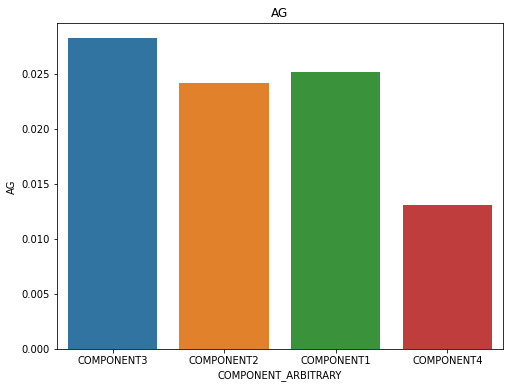

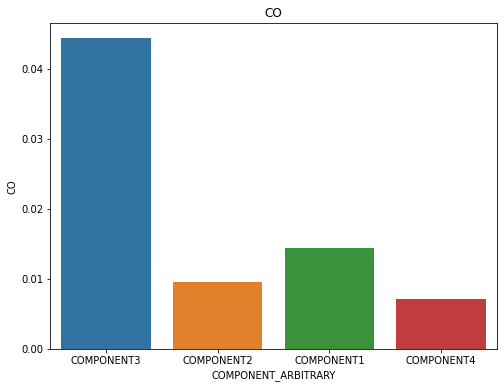

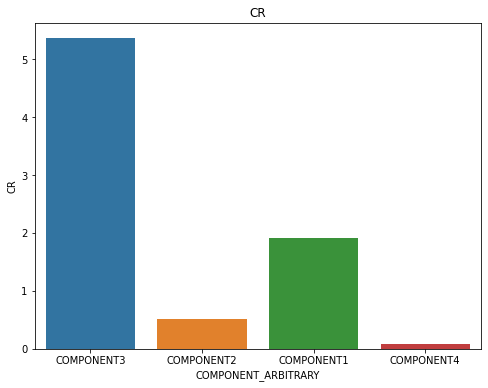

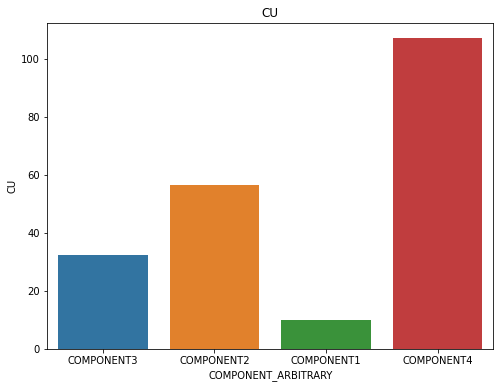

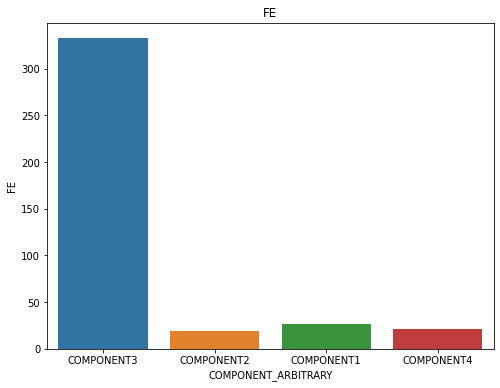

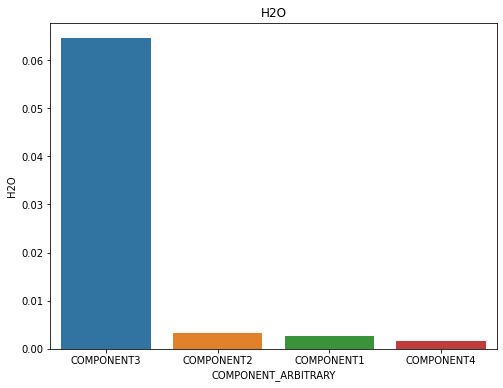

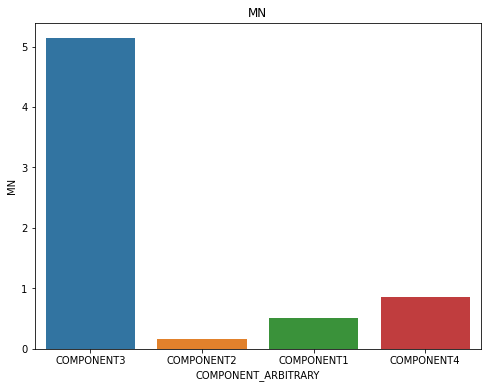

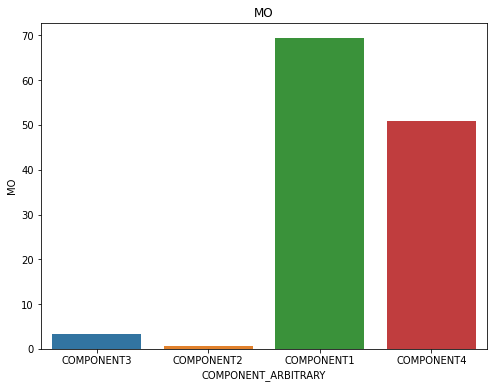

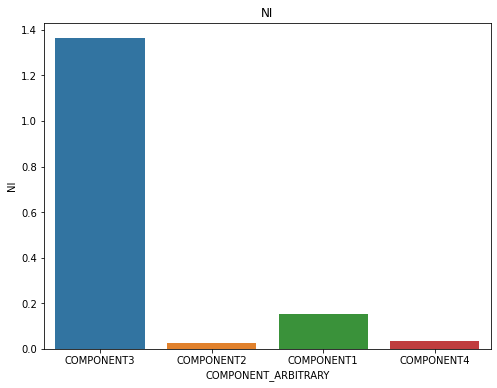

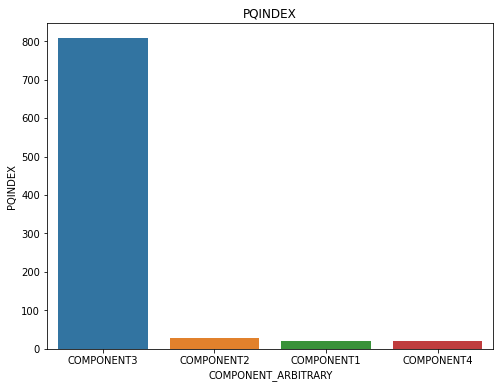

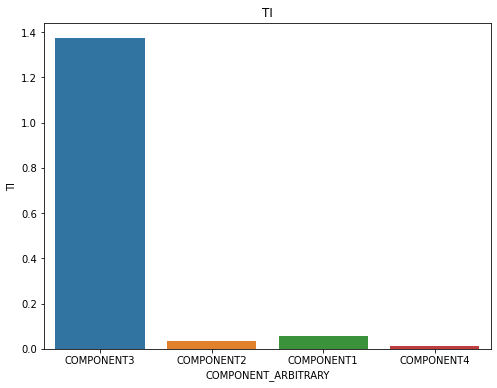

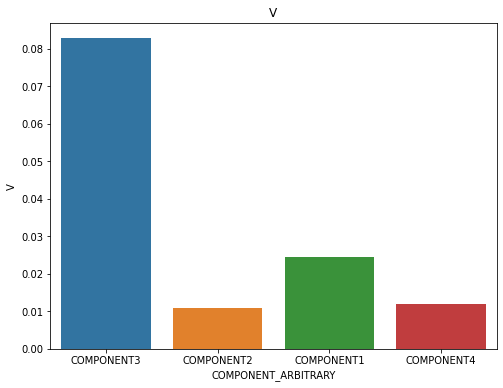

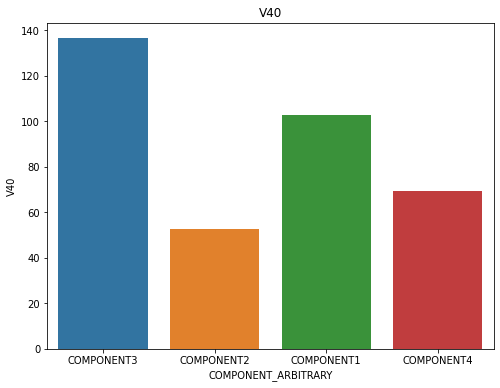

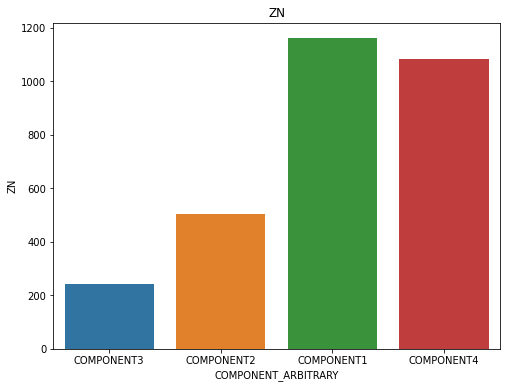

In [20]:
test_list = ['AG','CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V',
       'V40', 'ZN']



for n in range(len(test_list)):
    plt.figure(figsize=(8, 6))
    plt.title(test_list[n])
    sns.barplot(data=train, x="COMPONENT_ARBITRARY", y=test_list[n], ci=None)
    plt.show()

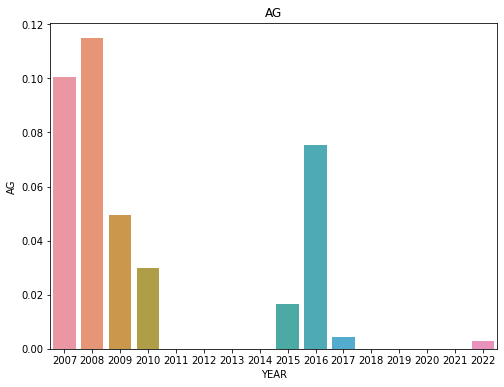

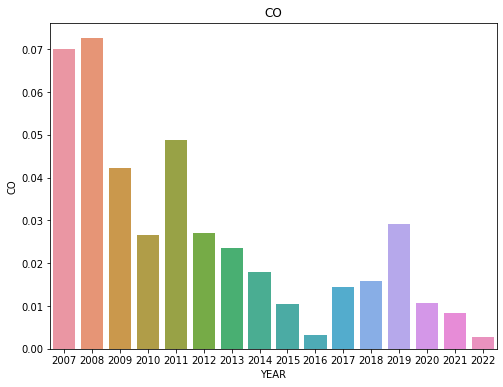

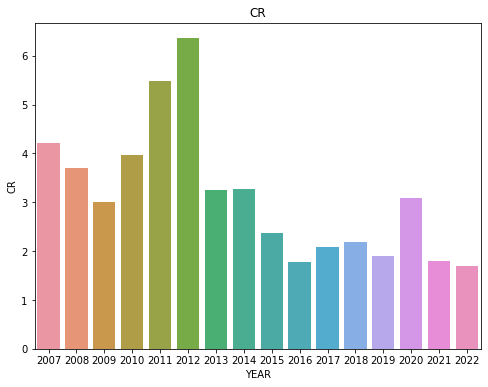

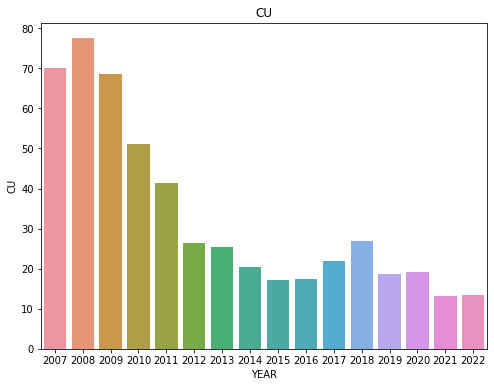

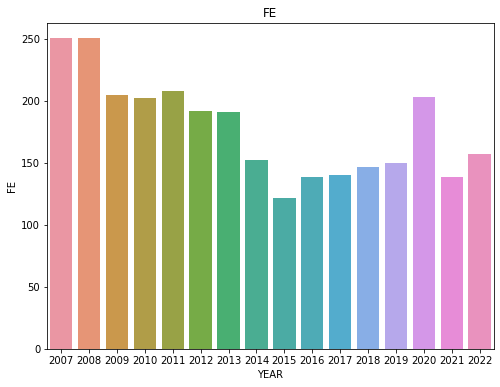

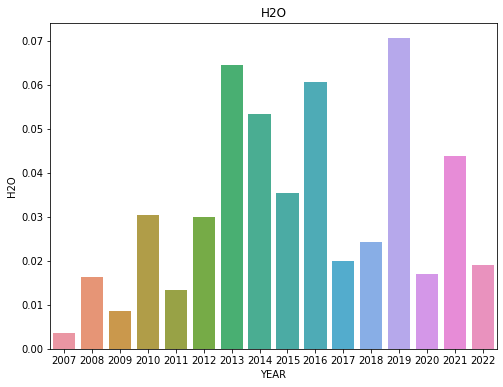

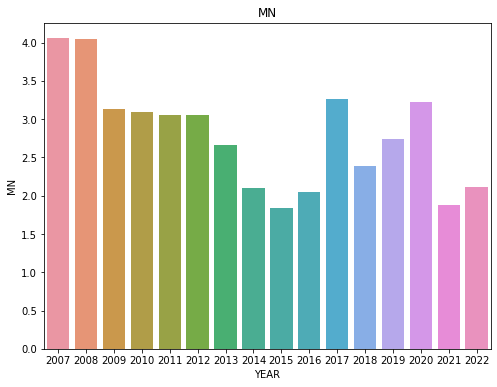

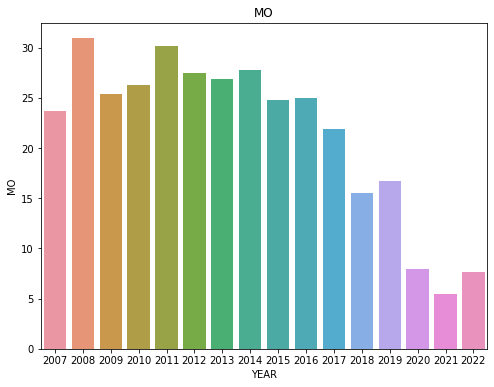

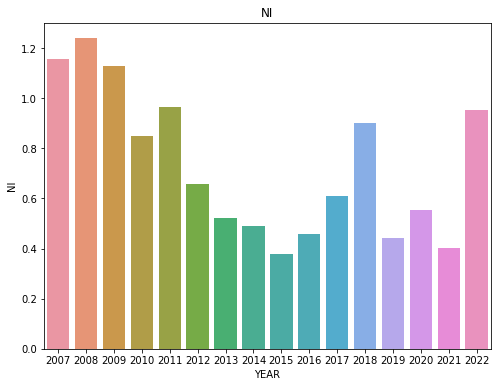

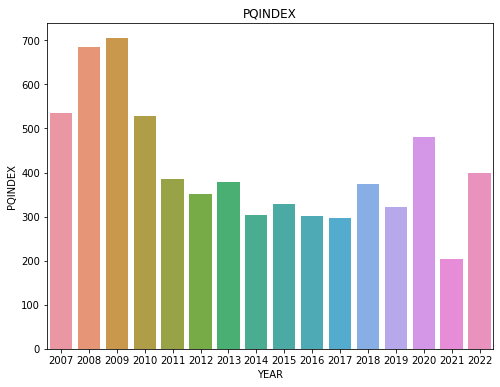

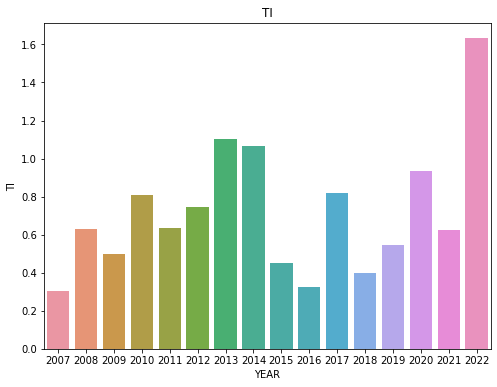

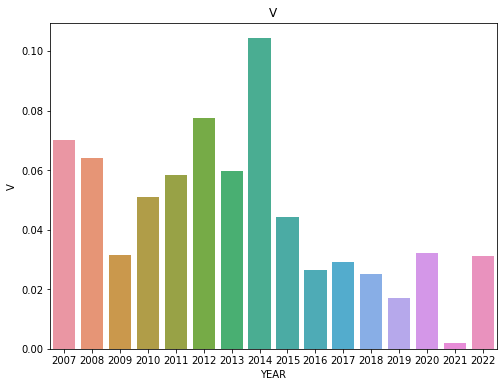

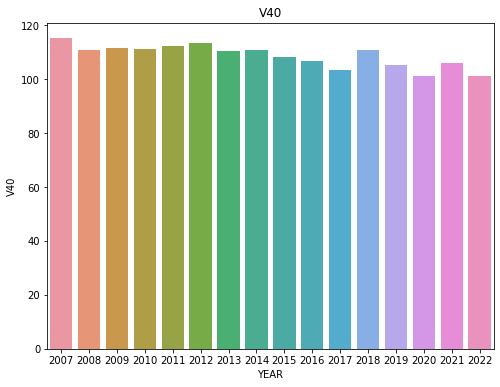

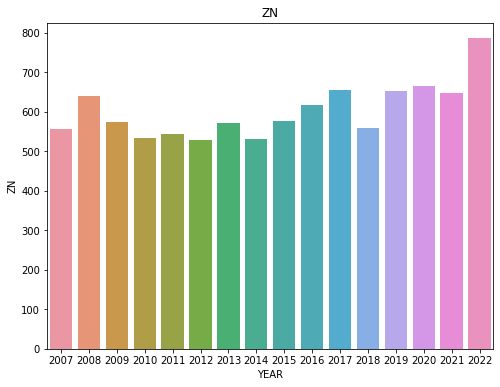

In [21]:
test_list = ['AG','CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V',
       'V40', 'ZN']



for n in range(len(test_list)):
    plt.figure(figsize=(8, 6))
    plt.title(test_list[n])
    sns.barplot(data=train, x="YEAR", y=test_list[n], ci=None)
    plt.show()

In [22]:
test.columns

Index(['ID', 'COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR', 'ANONYMOUS_2', 'AG',
       'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V',
       'V40', 'ZN'],
      dtype='object')

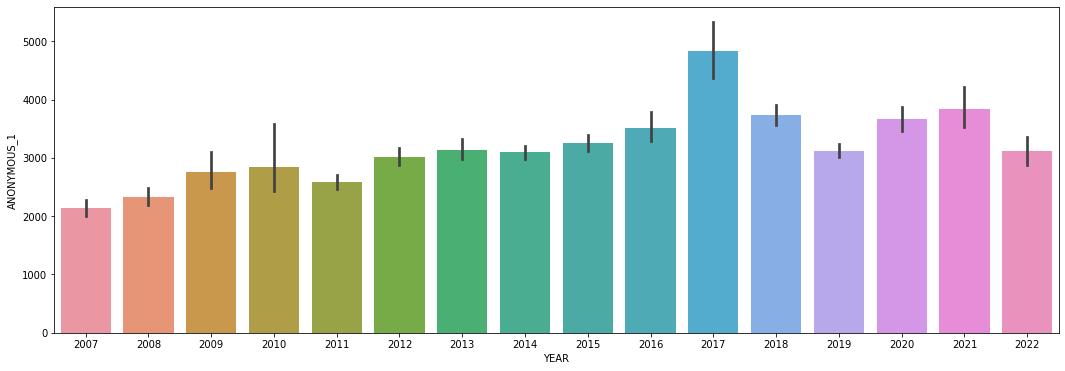

In [23]:
plt.figure(figsize = (18,6))
sns.barplot(data=train, x="YEAR", y="ANONYMOUS_1")

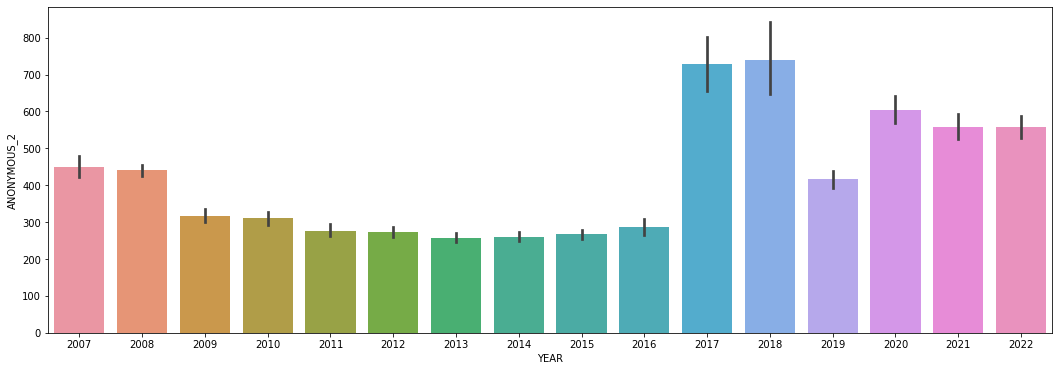

In [24]:
plt.figure(figsize = (18,6))
sns.barplot(data=train, x="YEAR", y="ANONYMOUS_2")

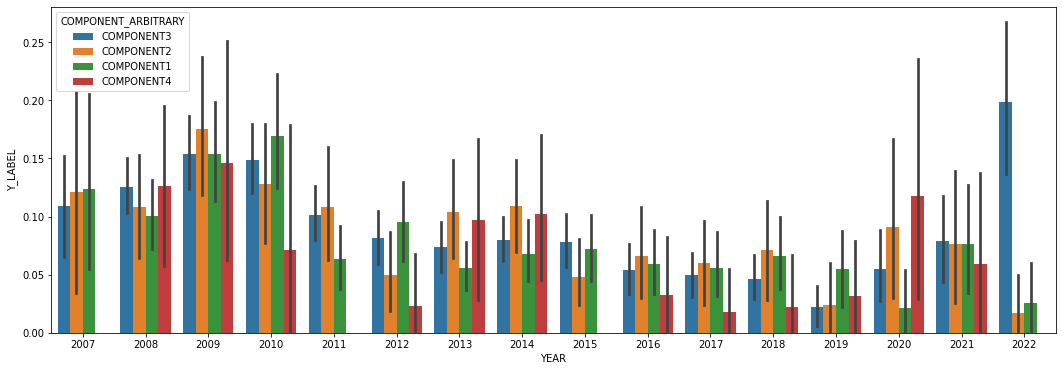

In [25]:
plt.figure(figsize = (18,6))
sns.barplot(data=train, x="YEAR", y="Y_LABEL", hue="COMPONENT_ARBITRARY")

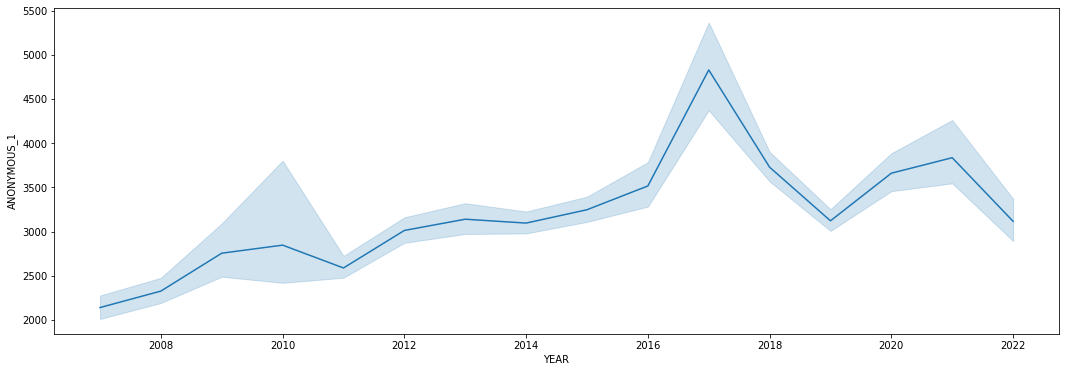

In [26]:
plt.figure(figsize = (18,6))
sns.lineplot(data=train, x="YEAR", y="ANONYMOUS_1")

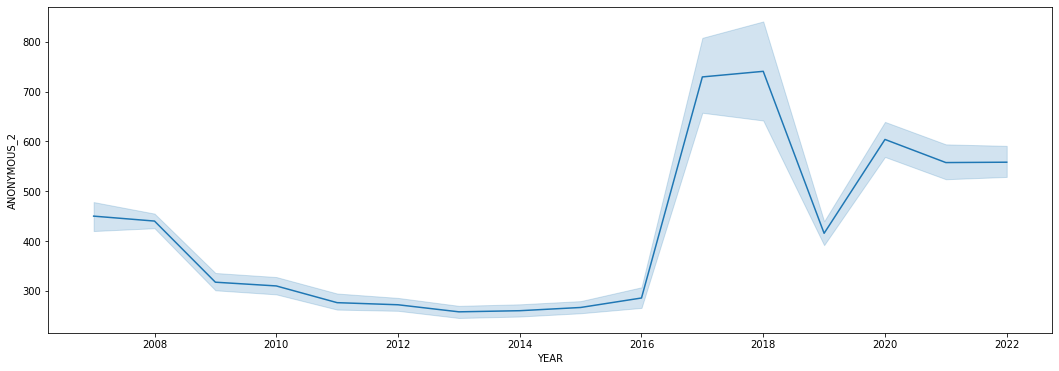

In [27]:
plt.figure(figsize = (18,6))
sns.lineplot(data=train, x="YEAR", y="ANONYMOUS_2")

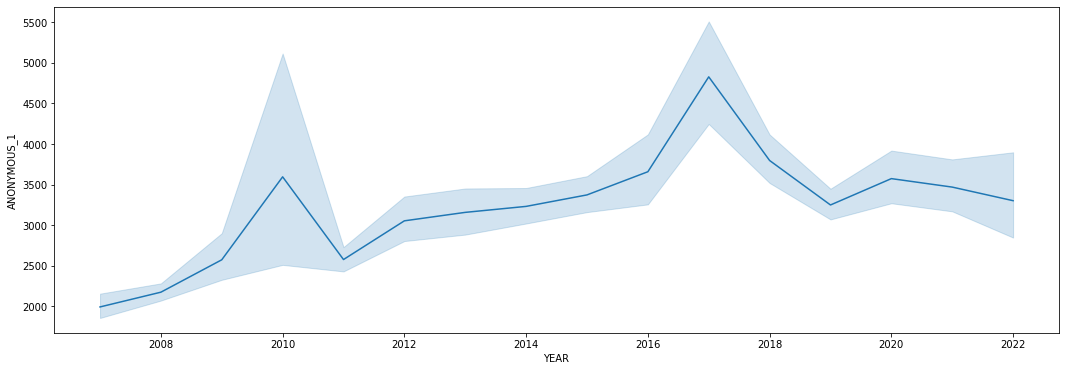

In [28]:
plt.figure(figsize = (18,6))
sns.lineplot(data=test, x="YEAR", y="ANONYMOUS_1")

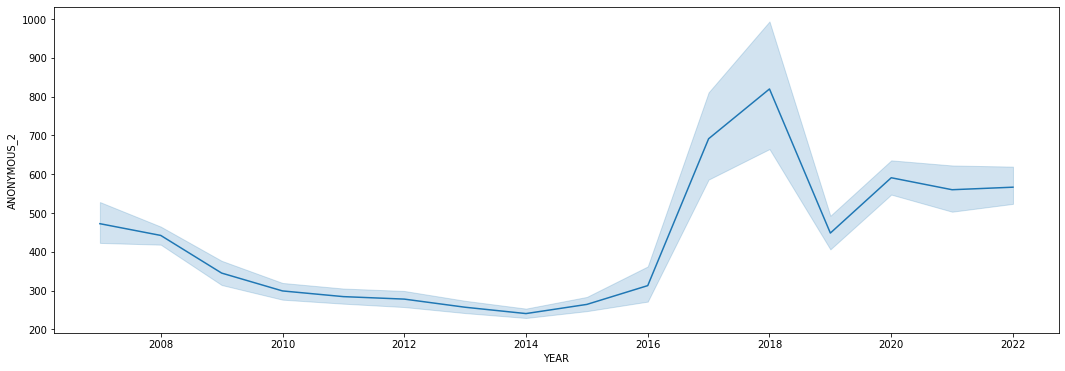

In [29]:
plt.figure(figsize = (18,6))
sns.lineplot(data=test, x="YEAR", y="ANONYMOUS_2")

In [45]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 54 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   14095 non-null  object 
 1   COMPONENT_ARBITRARY  14095 non-null  object 
 2   ANONYMOUS_1          14095 non-null  int64  
 3   YEAR                 14095 non-null  int64  
 4   SAMPLE_TRANSFER_DAY  14095 non-null  int64  
 5   ANONYMOUS_2          14095 non-null  int64  
 6   AG                   14095 non-null  int64  
 7   AL                   14095 non-null  int64  
 8   B                    14095 non-null  int64  
 9   BA                   14095 non-null  int64  
 10  BE                   14095 non-null  int64  
 11  CA                   14095 non-null  int64  
 12  CD                   12701 non-null  float64
 13  CO                   14095 non-null  int64  
 14  CR                   14095 non-null  int64  
 15  CU                   14095 non-null 

In [60]:
# train 결측치, drop 처리
train = train.fillna(0)

COMPONENT_ARBITRARY_map = {"COMPONENT1" : 1, "COMPONENT2" : 2, "COMPONENT3" : 3, "COMPONENT4" : 4}
train.COMPONENT_ARBITRARY = train.COMPONENT_ARBITRARY.map(COMPONENT_ARBITRARY_map)

# train = train.drop(["ID","YEAR"], axis = 1)

In [62]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 52 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   COMPONENT_ARBITRARY  14095 non-null  int64  
 1   ANONYMOUS_1          14095 non-null  int64  
 2   SAMPLE_TRANSFER_DAY  14095 non-null  int64  
 3   ANONYMOUS_2          14095 non-null  int64  
 4   AG                   14095 non-null  int64  
 5   AL                   14095 non-null  int64  
 6   B                    14095 non-null  int64  
 7   BA                   14095 non-null  int64  
 8   BE                   14095 non-null  int64  
 9   CA                   14095 non-null  int64  
 10  CD                   14095 non-null  float64
 11  CO                   14095 non-null  int64  
 12  CR                   14095 non-null  int64  
 13  CU                   14095 non-null  int64  
 14  FH2O                 14095 non-null  float64
 15  FNOX                 14095 non-null 

In [63]:
from sklearn.model_selection import train_test_split

X = train.drop(columns = "Y_LABEL") #feature vector
y = train.Y_LABEL # target value

# 트테트테(트벨트벨)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(12685, 51) (1410, 51) (12685,) (1410,)


In [64]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12685 entries, 7182 to 7270
Data columns (total 51 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   COMPONENT_ARBITRARY  12685 non-null  int64  
 1   ANONYMOUS_1          12685 non-null  int64  
 2   SAMPLE_TRANSFER_DAY  12685 non-null  int64  
 3   ANONYMOUS_2          12685 non-null  int64  
 4   AG                   12685 non-null  int64  
 5   AL                   12685 non-null  int64  
 6   B                    12685 non-null  int64  
 7   BA                   12685 non-null  int64  
 8   BE                   12685 non-null  int64  
 9   CA                   12685 non-null  int64  
 10  CD                   12685 non-null  float64
 11  CO                   12685 non-null  int64  
 12  CR                   12685 non-null  int64  
 13  CU                   12685 non-null  int64  
 14  FH2O                 12685 non-null  float64
 15  FNOX                 12685 non-nul

In [65]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm.sklearn import LGBMClassifier

clf = RandomForestClassifier(random_state=42)
clf2 = LGBMClassifier(random_state=42)

clf.fit(X_train, y_train)
clf2.fit(X_train, y_train)

LGBMClassifier(random_state=42)

In [66]:
from sklearn.metrics import f1_score

pred_train= clf.predict(X_train)
pred_val = clf.predict(X_val)

pred_train2 = clf2.predict(X_train)
pred_val2 = clf2.predict(X_val)

print("----- Random Forest -----")
print("Train f1_score : %.4f" % f1_score(y_train, pred_train))
print("Validation f1_score : %.4f" % f1_score(y_val, pred_val))
print("\n----- LGBMClassifier -----")
print("Train f1_score : %.4f" % f1_score(y_train, pred_train2))
print("Validation f1_score : %.4f" % f1_score(y_val, pred_val2))

----- Random Forest -----
Train f1_score : 0.9995
Validation f1_score : 0.6782

----- LGBMClassifier -----
Train f1_score : 0.8650
Validation f1_score : 0.7006


In [80]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer



# LGBMClassifier()
param_grid = {
        'n_estimators' : [50, 250],
        'num_leaves' : [62, 123],
        'learning_rate' : [0.1, 0.05],
        'min_child_samples' : [20, 25],
        'random_state' : [42]
}


f1_score_func = make_scorer(f1_score)

gcv = GridSearchCV(LGBMClassifier(), param_grid, scoring=f1_score_func, verbose=1)
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.1, 0.05],
                         'min_child_samples': [20, 25],
                         'n_estimators': [50, 250], 'num_leaves': [62, 123],
                         'random_state': [42]},
             scoring=make_scorer(f1_score), verbose=1)

In [81]:
best_model = gcv.best_estimator_
best_model

LGBMClassifier(n_estimators=250, num_leaves=123, random_state=42)

In [82]:
pred_train2 = best_model.predict(X_train)
pred_val2 = best_model.predict(X_val)


print("\n----- LGBMClassifier -----")
print("Train f1_score : %.4f" % f1_score(y_train, pred_train2))
print("Validation f1_score : %.4f" % f1_score(y_val, pred_val2))


----- LGBMClassifier -----
Train f1_score : 1.0000
Validation f1_score : 0.6857


In [95]:
# For Classifier

def optimizer(trial, X, y, K):
    
    import os
    LGBMClassifier()
    param = {
        'verbose': 0,
        'max_depth': trial.suggest_int('max_depth', 8, 20),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1)
        #"device" : 'gpu'
    }

    model = LGBMClassifier(**param, n_jobs=os.cpu_count())
    
    # K-Fold Cross validation을 구현합니다.
    from sklearn.model_selection import StratifiedKFold
    folds = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        score = f1_score(y_val, preds)
        scores.append(score)
    
    del model
    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(scores)

In [96]:
K = 5 # Kfold 수
opt_func = partial(optimizer, X=X_train, y=y_train, K=K)

lgbm_study = optuna.create_study(study_name="LGBM", direction="maximize") # regression task에서 R^2를 최대화!
lgbm_study.optimize(opt_func, n_trials=30)

[I 2022-11-16 09:10:23,203] A new study created in memory with name: LGBM
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  del sys.path[0]
[I 2022-11-16 09:10:54,071] Trial 0 finished with value: 0.0 and parameters: {'max_depth': 16, 'learning_rate': 3.258931037591258e-05, 'n_estimators': 960, 'min_child_samples': 64, 'subsample': 0.5230980668191247}. Best is trial 0 with value: 0.0.
/usr/local/lib/python3.7/dist-packages/i

In [97]:
lgbm_study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_max_depth,params_min_child_samples,params_n_estimators,params_subsample,state
0,0,0.000000,2022-11-16 09:10:23.206502,2022-11-16 09:10:54.071098,0 days 00:00:30.864596,3.258931e-05,16,64,960,0.523098,COMPLETE
1,1,0.000000,2022-11-16 09:10:54.079047,2022-11-16 09:11:13.504467,0 days 00:00:19.425420,9.754381e-07,20,76,739,0.753658,COMPLETE
2,2,0.000000,2022-11-16 09:11:13.511379,2022-11-16 09:11:22.437436,0 days 00:00:08.926057,6.915779e-07,8,39,345,0.930540,COMPLETE
3,3,0.646218,2022-11-16 09:11:22.445539,2022-11-16 09:11:27.061241,0 days 00:00:04.615702,8.919251e-03,18,10,141,0.642502,COMPLETE
4,4,0.000000,2022-11-16 09:11:27.069083,2022-11-16 09:11:32.918415,0 days 00:00:05.849332,5.397509e-08,11,51,221,0.938666,COMPLETE
5,5,0.655970,2022-11-16 09:11:32.925928,2022-11-16 09:12:06.759614,0 days 00:00:33.833686,7.967388e-03,18,26,968,0.822109,COMPLETE
6,6,0.000000,2022-11-16 09:12:06.765402,2022-11-16 09:12:24.575713,0 days 00:00:17.810311,1.175564e-07,13,73,695,0.992509,COMPLETE
7,7,0.000000,2022-11-16 09:12:24.578735,2022-11-16 09:12:50.302811,0 days 00:00:25.724076,1.587362e-05,8,8,863,0.587715,COMPLETE
8,8,0.647108,2022-11-16 09:12:50.309158,2022-11-16 09:13:19.395303,0 days 00:00:29.086145,2.675584e-03,14,91,965,0.844434,COMPLETE
9,9,0.000000,2022-11-16 09:13:19.402731,2022-11-16 09:13:31.273604,0 days 00:00:11.870873,1.066926e-08,11,47,345,0.689088,COMPLETE


In [98]:
print("Best Score: %.4f" % lgbm_study.best_value) # best score 출력
print("Best params: ", lgbm_study.best_trial.params) # best score일 때의 하이퍼파라미터들

Best Score: 0.6597
Best params:  {'max_depth': 17, 'learning_rate': 0.009659670943088651, 'n_estimators': 980, 'min_child_samples': 37, 'subsample': 0.7474891572840545}


In [99]:
# 실험 기록 시각화
optuna.visualization.plot_optimization_history(lgbm_study)

In [100]:
# hyper-parameter들의 중요도
optuna.visualization.plot_param_importances(lgbm_study)

In [101]:
trial = lgbm_study.best_trial
trial_params = trial.params

final_lgb_model = LGBMClassifier(**trial_params)
final_lgb_model.fit(X, y) # finalize model

LGBMClassifier(learning_rate=0.009659670943088651, max_depth=17,
               min_child_samples=37, n_estimators=980,
               subsample=0.7474891572840545)

#### 다중공선성 처리

In [ ]:
# 상관계수가 threshold(e.g. 0.8)를 넘기는 feature들을 제거합니다.
threshold = 

#### Encoding Categorical Features

In [ ]:
# dtype이 object인 변수들 처리.


#### feature extraction

- 차원의 저주를 해결하거나, 데이터의 feature 조합을 이용하는 새로운 feature를 생성할 때, PCA를 사용합니다.

- 분석에 사용할 feature를 선택하는 과정도 포함합니다.

In [ ]:
# PCA 적용
from sklearn.decomposition import PCA

if feature_reducing:
    pca = PCA(n_components=0.9) # PCA(n_components=6)
    pca_data = pca.fit_transform(X)

### 4. 학습 데이터 분할

In [ ]:
# 첫번째 테스트용으로 사용하고, 실제 학습시에는 K-Fold CV를 사용합니다.
# train : test = 8 : 2
from sklearn.model_selection import train_test_split

X = 
y =

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

### 5. 학습 및 평가

In [ ]:
# 간단하게 LightGBM 테스트
# 적당한 hyper-parameter 조합을 두었습니다. (항상 best는 아닙니다. 예시입니다.)

param_grid = {
    "max_bin" : 20,
    "learning_rate" : 0.0025,
    "objective" : "regression",
    "boosting_type" : "gbdt",
    "metric" : "mae",
    "sub_feature" : 0.345,
    "bagging_fraction" : 0.85,
    "bagging_freq" : 40,
    "num_leaves" : 512,
    "min_data" : 500,
    "min_hessian" : 0.05,
    "verbose" : 2,
    "feature_fraction_seed" : 2,
    "bagging_seed" : 3
}

model = LGBMRegressor(**param_grid)

In [ ]:
print("\nFitting LightGBM...")
model.fit(X_train, y_train)

In [ ]:
# metric은 그때마다 맞게 바꿔줘야 합니다.
evaluation_metric = 

In [ ]:
print("Prediction")
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)


train_score = evaluation_metric(y_train, pred_train)
test_score = evaluation_metric(y_test, pred_test)

print("Train Score : %.4f" % train_score)
print("Test Score : %.4f" % test_score)

### 6. Hyper-parameter Tuning

> GridSearchCV

** LightGBM의 hyperparameter **

[Official Documentation] https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html 

[Blog 1] https://smecsm.tistory.com/133

[Blog 2] https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

[Blog 3] https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/

In [ ]:
# GridSearchCV를 이용하여 가장 좋은 성능을 가지는 모델을 찾아봅시다. (이것은 첫번째엔 선택입니다.)
# Lightgbm은 hyper-parameter의 영향을 많이 받기 때문에, 저는 보통 맨처음에 한번 정도는 가볍게 GCV를 해봅니다.
# 성능 향상이 별로 없다면, lightgbm으로 돌린 대략적인 성능이 이 정도라고 생각하면 됩니다.
# 만약 성능 향상이 크다면, 지금 데이터는 hyper-parameter tuning을 빡빡하게 하면 성능 향상이 많이 이끌어 낼 수 있습니다.

from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth" : [8, 16, None],
    "n_estimators" : [100, 300, 500],
    "max_bin" : [20],
    "learning_rate" : [0.001, 0.0025, 0.003],
    "objective" : ["regression"],
    "boosting_type" : ["gbdt"],
    "metric" : ["mae"],
    "sub_feature" : [0.345],
    "bagging_fraction" : [0.7, 0.75, 0.85],
    "bagging_freq" : [40],
    "num_leaves" : [256, 512],
    "min_data" : [500],
    "verbose" : [-1], # 필수
    "min_hessian" : [0.05],
    "feature_fraction_seed" : [2],
    "bagging_seed" : [3]
}


gcv = GridSearchCV(estimator=model, param_grid=param_grid, cv=5,
                  n_jobs=-1, verbose=1)

gcv.fit(X_train, y_train)
print("Best Estimator : ", gcv.best_estimator_)

In [ ]:
print("Prediction with Best Estimator")
gcv_pred_train = gcv.predict(X_train)
gcv_pred_test = gcv.predict(x_test)

gcv_train_score = evaluation_metric(y_train, gcv_pred_train)
gcv_test_score = evaluation_metric(y_test, gcv_pred_test)

print("Train MAE Score : %.4f" % gcv_train_score)
print("Test MAE Score : %.4f" % gcv_test_score)

In [ ]:
print("Performance Gain") # 이걸로 성능 향상 확인.
print("in train : ", (train_score - gcv_train_score))
print("in test : ", (test_score - gcv_test_score))

> optuna를 사용해봅시다 !

In [ ]:
def optimizer(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    n_estimators = 
    max_depth = 
    max_features = 
    
    
    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = RandomForestRegressor(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 max_features=max_features)
    
    
    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K)
    losses = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        loss = mean_absolute_error(y_val, preds)
        losses.append(loss)
    
    
    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(losses)

In [ ]:
K = # Kfold 수
opt_func = partial(optimizer, X=X_train, y=y_train, K)

study = optuna.create_study(direction="minimize") # 최소/최대 어느 방향의 최적값을 구할 건지.
study.optimize(opt_func, n_trials=5)

In [ ]:
# optuna가 시도했던 모든 실험 관련 데이터
study.trials_dataframe()

In [ ]:
print("Best Score: %.4f" % study.best_value) # best score 출력
print("Best params: ", study.best_trial.params) # best score일 때의 하이퍼파라미터들

In [ ]:
# 실험 기록 시각화
optuna.visualization.plot_optimization_history(study)

In [ ]:
# hyper-parameter들의 중요도
optuna.visualization.plot_param_importances(study)

### 7. 테스트 및 제출 파일 생성

In [ ]:
model = RandomForestRegressor(n_estimators=study.best_trial.params["n_estimators"],
                                 max_depth=study.best_trial.params["max_depth"],
                                 max_features=study.best_trial.params["max_features"])

model.fit(X_train, y_train)
preds = model.predict(X_test)
preds

In [ ]:
X_test # 원본 데이터랑 id가 맞는지 확인 해보기!

In [ ]:
submission = pd.DataFrame() # submission을 생성합니다.
submission

In [ ]:
submission.reset_index(drop=True).to_csv("submission.csv", index=False)